# Visium DLPFC

In this notebook we demonstrate how mosna can be used to analyze spatiallly resolved omics data.  
The data used is from the publication by [Maynard et al.](https://www.nature.com/articles/s41593-020-00787-0) "Transcriptome-scale spatial gene expression in the human dorsolateral prefrontal cortex".  
Here 12 samples were processed with the [Visium](https://www.science.org/doi/10.1126/science.aaf2403) platform to produce maps of transcripts per spots.  

## Imports and data loading

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter

import anndata as ad
import scanpy as sc
import scvi

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

Global seed set to 0


In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

### Objects data

Load files that contains all the detected objects (the cells) across all samples and clinical data.  
Data is available here: https://github.com/LieberInstitute/HumanPilot/tree/master and at [Globus](http://research.libd.org/globus/) (`jhpce#HumanPilot10x`).

In [3]:
data_dir = Path("../../HumanPilot/10X/")
sample_ids = [
    '151507', 
    '151508', 
    '151509', 
    '151510', 
    '151669', 
    '151670', 
    '151671', 
    '151672', 
    '151673', 
    '151674', 
    '151675', 
    '151676'
]

str_preprocess = ''

In [4]:
annotations = pd.read_csv(data_dir / 'barcode_level_layer_map.tsv', sep='\t', header=None)
annotations.columns = ['barcodes', 'sample_id', 'layer']
# make unique barcodes with sample_id
annotations['barcodes'] = annotations['barcodes'] + '-' + annotations['sample_id'].astype(str)
annotations

barcodes  sample_id layer
0      AAACAACGAATAGTTC-1-151507     151507    L1
1      AAACAAGTATCTCCCA-1-151507     151507    L3
2      AAACAATCTACTAGCA-1-151507     151507    L1
3      AAACACCAATAACTGC-1-151507     151507    WM
4      AAACAGCTTTCAGAAG-1-151507     151507    L6
...                          ...        ...   ...
47324  TTGTTGTGTGTCAAGA-1-151676     151676    L6
47325  TTGTTTCACATCCAGG-1-151676     151676    WM
47326  TTGTTTCATTAGTCTA-1-151676     151676    WM
47327  TTGTTTCCATACAACT-1-151676     151676    L6
47328  TTGTTTGTGTAAATTC-1-151676     151676    L1

[47329 rows x 3 columns]

In [5]:
annotations['sample_id'].value_counts()

sample_id
151509    4788
151510    4595
151508    4381
151507    4221
151671    4093
151672    3888
151669    3636
151674    3635
151673    3611
151675    3566
151670    3484
151676    3431
Name: count, dtype: int64

In [ ]:
# # rename files to use `sc.read_visium`
# for sample_id in sample_ids:
#     path_dir = data_dir / f'{sample_id}'
#     path_dir_spatial = path_dir / 'spatial'
#     path_dir_spatial.mkdir(parents=True, exist_ok=True)

#     for path, directories, files in os.walk(path_dir):
#         for file in files:
#             if file.startswith(sample_id):
#                 new_name = file.replace(f'{sample_id}_', '')
#                 os.rename(os.path.join(path, file), os.path.join(path, new_name))
#             if file == 'tissue_positions_list.txt':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, 'tissue_positions_list.csv'))
#             elif file.endswith('res_image.png'):
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))
#             elif file == 'scalefactors_json.json':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))

### Explore single sample

In [ ]:
hvgs=5000

sample_id = sample_ids[0]
sample_dir = data_dir / f'{sample_id}'
adata = sc.read_visium(path=sample_dir)
adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=hvgs,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# make unique barcodes with sample_id
adata.obs.index = adata.obs.index + '-' + str(sample_id)

In [ ]:
adata

In [ ]:
layer_guess = annotations.loc[annotations['sample_id'] == int(sample_id)]
layer_guess.index = layer_guess['barcodes']
layer_guess.index.name = None
layer_guess = layer_guess.drop(columns=['barcodes', 'sample_id'])

adata.obs['layer_guess'] = layer_guess
adata.obs.loc[adata.obs['layer_guess'].isna(), 'layer_guess'] = 'none'

In [ ]:
adata.obs

In [ ]:
adata.obs['layer_guess'].value_counts()

In [ ]:
# make common color mapper
cycle_cmap = False

nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = len(uniq)
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [ ]:
nodeclusters_color_mapper

In [ ]:
adata.uns['spatial'][sample_id]['images']['hires'].shape

In [ ]:
plt.imshow(adata.uns['spatial'][sample_id]['images']['hires']);

In [ ]:
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=1, marker='.');

In [ ]:
coords = adata.obsm['spatial']
pairs = ty.build_lattice(coords)

In [ ]:
fig, ax = ty.plot_network(
    coords, pairs, labels=nodes_labels,
    color_mapper=nodeclusters_color_mapper, 
    legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
    )
plt.title("sample {}".format(sample_id));

In [ ]:
adata

In [ ]:
adata.layers['counts']

In [ ]:
n_zeros = np.sum(adata.layers['counts'] == 0)
n_finite = adata.layers['counts'].size
m, n = adata.layers['counts'].shape
print(m * n == n_finite + n_zeros)
print(n_zeros / (m *n))

## Cellular neighborhoods

In [ ]:
# order = 1
# var_type = 'genexp'
# stat_names = 'mean-std'
# # aggreg_vars = pheno_cols

# # For UMAP visualization
# marker = '.'
# size_points = 10

# nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
# nas_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
order = 1
stat_funcs='default'
stat_names='default'
# stat_funcs = np.mean
# stat_names = 'mean'
var_names = adata.var.loc[adata.var['highly_variable']].index
    
nas = mosna.make_features_NAS(
    adata.layers['counts'].toarray(), 
    pairs, 
    order=order, 
    var_names=var_names, 
    stat_funcs=stat_funcs, 
    stat_names=stat_names, 
    )

### Pre-process all samples

In [6]:
cluster_ids = {
    '151507': 7, 
    '151508': 7, 
    '151509': 7, 
    '151510': 7, 
    '151669': 5, 
    '151670': 5, 
    '151671': 5, 
    '151672': 5, 
    '151673': 7, 
    '151674': 7, 
    '151675': 7, 
    '151676': 7,
    }

patient_ids = {
    '151507': 0, 
    '151508': 0, 
    '151509': 0, 
    '151510': 0, 
    '151669': 1, 
    '151670': 1, 
    '151671': 1, 
    '151672': 1, 
    '151673': 2, 
    '151674': 2, 
    '151675': 2, 
    '151676': 2,
    }

In [ ]:
# cohort aggregation
# compare HVG selection, from https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_03_integration.html
hvgs = 5000
remove_none_spots = True
batch_key = 'sample' # or 'patient'
hvg_on = 'sample' # or 'all or 'patient'
n_common_batches = 4
str_preprocess += f'_hvg_on-{hvg_on}-{n_common_batches}'

adatas = []
for sample_id, n_clusters in cluster_ids.items():
    sample_dir = data_dir / f'{sample_id}'
    adata = sc.read_visium(path=sample_dir)
    adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata.obs['sample'] = [sample_id] * adata.shape[0]
    adata.obs['patient'] = [patient_ids[sample_id]] * adata.shape[0]

    # make unique barcodes with sample_id
    adata.obs.index = adata.obs.index + '-' + str(sample_id)
    
    adatas.append(adata)

adata = ad.concat(adatas, pairwise=True)
# adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


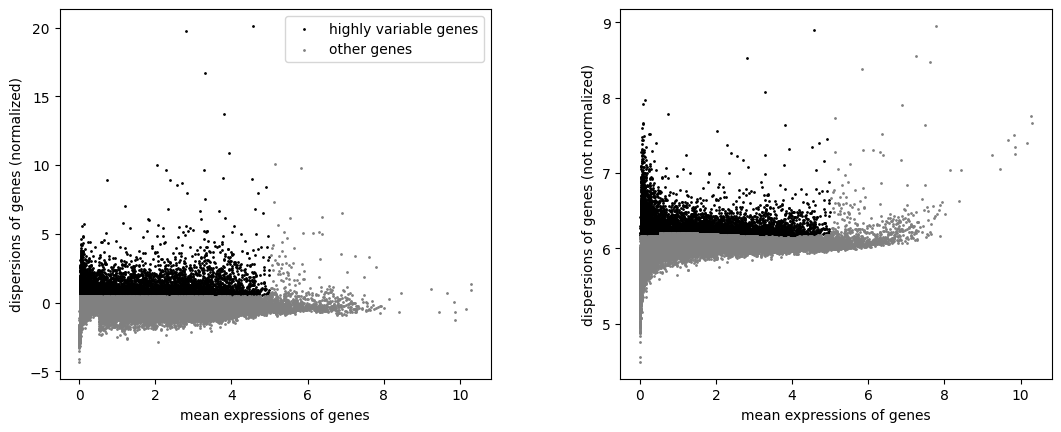

Highly variable genes: 5284


In [7]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.5)

sc.pl.highly_variable_genes(adata)

print("Highly variable genes: %d"%sum(adata.var.highly_variable))

var_genes_all = adata.var.highly_variable

In [ ]:
# Detect variable genes in each dataset separately using the batch_key parameter.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')
print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))
print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())
var_genes_batch = adata.var.highly_variable_nbatches > 0

In [11]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata.var.highly_variable_nbatches ==3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata.var.highly_variable_intersection))

Any batch var genes: 14162
All data var genes: 5284
Overlap: 4362
Variable genes in all batches: 2583
Overlap batch instersection and all: 6


In [ ]:
# cohort aggregation
hvgs = 5000
remove_none_spots = True
batch_key = 'sample' # or 'patient'
hvg_on = 'sample' # or 'all or 'patient'


var_genes_all = []
for sample_id, n_clusters in cluster_ids.items():
    sample_dir = data_dir / f'{sample_id}'
    adata = sc.read_visium(path=sample_dir)
    adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata.obs['sample'] = [sample_id] * adata.shape[0]
    adata.obs['patient'] = [patient_ids[sample_id]] * adata.shape[0]

    # make unique barcodes with sample_id
    adata.obs.index = adata.obs.index + '-' + str(sample_id)

    sc.pp.filter_genes(adata, min_counts=3)
    sc.pp.filter_cells(adata, min_counts=3)

    adata.layers["counts"] = adata.X.copy()

    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=hvgs,
        subset=True,
        layer="counts",
        flavor="seurat_v3",
    )
    var_genes_all.append(adata.var.highly_variable.index.tolist())

hvg_names, hvg_counts = np.unique(var_genes_all, return_counts=True)
df_hvg = pd.DataFrame({'gene': hvg_names, 'count': hvg_counts})
df_hvg = df_hvg.sort_values('count', ascending=False)

In [25]:
df_hvg[df_hvg['count'] >= 12]

gene  count
2496      ARL4C     12
7263      IGHA2     12
9646     NDUFA4     12
10852     PLIN1     12
11826      RGS5     12
...         ...    ...
12658   SLC17A7     12
7181       ICA1     12
12252      SCG5     12
6007   FGFR1OP2     12
12089     RSBN1     12

[408 rows x 2 columns]

In [29]:
len(df_hvg[df_hvg['count'] >= 9])

1175

In [34]:
hvg_names = df_hvg.loc[df_hvg['count'] >= 9, 'gene'].values

In [5]:
# cohort aggregation with hvg selected and preprocessing performed per sample
hvgs = 5000
remove_none_spots = True
batch_key = 'sample' # or 'patient'
hvg_on = 'sample' # or 'all or 'patient'
n_common_batches = 9
str_preprocess += f'_hvg_on-{hvg_on}-{n_common_batches}'

adatas = []
for sample_id, n_clusters in cluster_ids.items():
    sample_dir = data_dir / f'{sample_id}'
    adata = sc.read_visium(path=sample_dir)
    adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata.obs['sample'] = [sample_id] * adata.shape[0]
    adata.obs['patient'] = [patient_ids[sample_id]] * adata.shape[0]

    # make unique barcodes with sample_id
    adata.obs.index = adata.obs.index + '-' + str(sample_id)

    sc.pp.filter_genes(adata, min_counts=3)
    sc.pp.filter_cells(adata, min_counts=3)

    adata.layers["counts"] = adata.X.copy()

    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)

    adata = adata = adata[:, hvg_names]
    adatas.append(adata)

adata = ad.concat(adatas, pairwise=True)

In [ ]:
# cohort aggregation, hvg and preprocessing performed on whole cohort
hvgs = 5000
remove_none_spots = True
batch_key = 'sample' # or 'patient'
hvg_on = 'sample' # or 'all or 'patient'
n_common_batches = 9
str_preprocess += f'_hvg_on-{hvg_on}-{n_common_batches}'

adatas = []
for sample_id, n_clusters in cluster_ids.items():
    sample_dir = data_dir / f'{sample_id}'
    adata = sc.read_visium(path=sample_dir)
    adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata.obs['sample'] = [sample_id] * adata.shape[0]
    adata.obs['patient'] = [patient_ids[sample_id]] * adata.shape[0]

    # make unique barcodes with sample_id
    adata.obs.index = adata.obs.index + '-' + str(sample_id)
    
    adatas.append(adata)

adata = ad.concat(adatas, pairwise=True)
# adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

if hvg_on == 'full':
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=hvgs,
        subset=True,
        layer="counts",
        flavor="seurat_v3",
    )
else:
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=hvgs,
        subset=True,
        layer="counts",
        flavor="seurat_v3",
        batch_key=batch_key,
    )
    # print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))
    print("Number of batches where gene is variable:")
    print(adata.var.highly_variable_nbatches.value_counts())
    var_genes_batch = adata.var.highly_variable_nbatches > 0
    # Select all genes that are variable in at least 2 datasets and use for remaining analysis.
    var_select = adata.var.highly_variable_nbatches >= n_common_batches
    var_genes = var_select.index[var_select]
    print('len(var_genes):', len(var_genes))
    adata = adata[:, var_genes]

In [41]:
# add manual annotations
layer_guess = annotations.copy()
layer_guess.index = layer_guess['barcodes']
layer_guess.index.name = None
layer_guess = layer_guess.drop(columns=['barcodes', 'sample_id'])
adata.obs['layer_guess'] = layer_guess
if remove_none_spots:
    adata = adata[~adata.obs['layer_guess'].isna()]
else:
    adata.obs.loc[adata.obs['layer_guess'].isna(), 'layer_guess'] = 'none'

# make common color mapper
nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = len(uniq)
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [ ]:
# adata.obs_names_make_unique() # manually done

In [ ]:
# batch correction
n_latent = 5
seed = 0
scvi.settings.seed = seed

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="patient")
model = scvi.model.SCVI(adata, n_latent=n_latent)
model.train(early_stopping=True)
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

In [ ]:
adata.write(data_dir / f"batch_corrected_hvgs{hvgs}_nlatent{n_latent}_joint.h5ad")

Use scanorama to perform batch correction

In [ ]:
import scanpy.external as sce

In [ ]:
sc.tl.pca(adata)
sce.pp.scanorama_integrate(adata, 'patient')

In [ ]:
adata.obsm['X_scanorama'].shape

#### Scanorama batch correction of counts

Scanpy makes it mandatory to run scanorama on PCA components, but we want batch-corrected gene expression, so we'll directly use scanorama.

In [46]:
# check batch effect first
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata.obs['patient'] = adata.obs['patient'].astype('category')

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


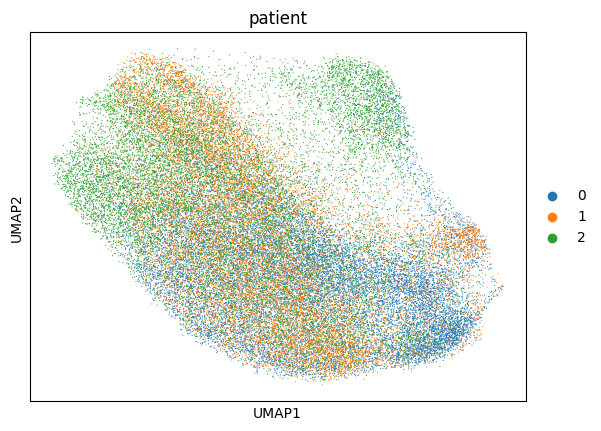

In [47]:
sc.pl.umap(
    adata, 
    color=['patient'],
)

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


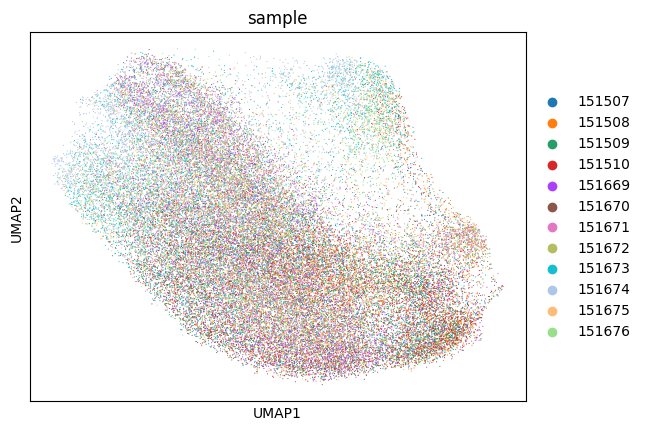

In [48]:
sc.pl.umap(
    adata, 
    color=['sample'],
)

In [11]:
adata

AnnData object with n_obs × n_vars = 47329 × 1889
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'patient', 'n_counts', 'layer_guess'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'patient_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [6]:
batch_key = 'patient'
# batch_key = 'sample'
str_preprocess += f'_scanorama_on_{batch_key}'

In [50]:
import scanorama

# # Integration.
# scanorama.integrate_scanpy(adatas)

# Batch correction.
# make list of AnnData object per batch key
uniq_keys = adata.obs[batch_key].unique()
adatas = [adata[adata.obs[batch_key] == key] for key in uniq_keys]

corrected = scanorama.correct_scanpy(adatas)

Found 1175 genes among all datasets
[[0.         0.64134826 0.35547286]
 [0.         0.         0.57592212]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


In [51]:
adata = ad.concat(corrected, pairwise=True)
# adata.obs_names_make_unique()
adata.write(data_dir / f"batch_corrected{str_preprocess}.h5ad")

In [7]:
adata = sc.read_h5ad(data_dir / f"batch_corrected{str_preprocess}.h5ad")

# make common color mapper
nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

nb_clust = len(uniq)
uniq = pd.Series(nodes_labels).value_counts().index

# choose colormap
clusters_cmap = mosna.make_cluster_cmap(uniq)
# make color mapper
# series to sort by decreasing order
n_colors = len(clusters_cmap)
nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [8]:
adata

AnnData object with n_obs × n_vars = 47329 × 1175
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'patient', 'n_counts', 'layer_guess'
    obsm: 'X_pca', 'X_umap', 'spatial'

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


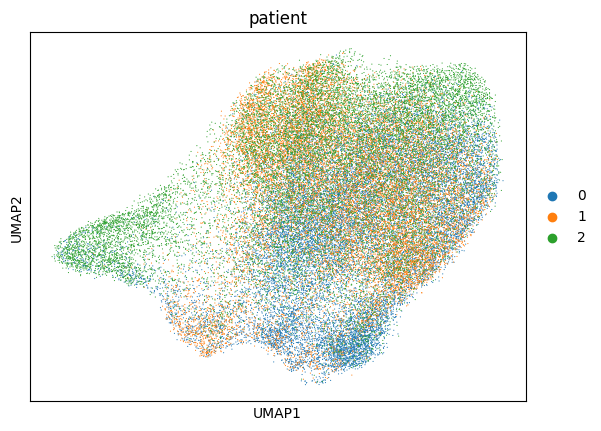

In [54]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=['patient'],
)

### All samples network reconstruction

In [9]:
# chose optional **additional** data transformation, knowing that
# the 'preprocessed' is already normalized and log1p
use_data = 'preprocessed'
# use_data = 'log1p'

processed_dir = Path('../data/processed/Visium_DLPFC')
# reconst_dir = processed_dir / f"samples_networks_hexagonal_lattice_data-{use_data}"
reconst_dir = processed_dir / f"batch_corrected{str_preprocess}" / f"samples_networks_hexagonal_lattice_data-{use_data}"
dir_fig_save = processed_dir / 'figures'
reconst_dir.mkdir(parents=True, exist_ok=True)
dir_fig_save.mkdir(parents=True, exist_ok=True)

uniq_patients = adata.obs['patient'].unique()
uniq_samples = adata.obs['sample'].unique()

In [56]:
make_figures = False

for sample_id in uniq_samples:
    print(f"processing sample {sample_id}")
    adaview = adata[adata.obs['sample'] == sample_id]
    patient_id = adaview.obs['patient'].iloc[0]

    coords = adaview.obsm['spatial']
    pairs = ty.build_lattice(coords)
    # add annotations
    nodes_labels = adaview.obs['layer_guess']

    if make_figures:
        fig, ax = ty.plot_network(
            coords, pairs, labels=nodes_labels,
            color_mapper=nodeclusters_color_mapper, 
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
            )
        title = f"patient-{patient_id}_sample-{sample_id}"
        plt.title(title);
        plt.axis('off');
        plt.savefig(str(dir_fig_save / title) + '.png', bbox_inches='tight', facecolor='white')
        # plt.show()
        plt.close(fig)


    edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
    edges.to_parquet(reconst_dir / f'edges_patient-{patient_id}_sample-{sample_id}.parquet', index=False)

    if use_data == 'preprocessed':
        data = adaview.X.toarray()
    elif use_data == 'log1p':
        data = np.log(adaview.X.toarray() + 1)
    nodes = pd.DataFrame(
        data=adaview.X.toarray(),
        columns=adaview.var_names,
        index=adaview.obs_names,
    )
    nodes.to_parquet(reconst_dir / f'nodes_patient-{patient_id}_sample-{sample_id}.parquet', index=False)

del data, nodes, edges, coords, pairs

processing sample 151507
processing sample 151508
processing sample 151509
processing sample 151510
processing sample 151669
processing sample 151670
processing sample 151671
processing sample 151672
processing sample 151673
processing sample 151674
processing sample 151675
processing sample 151676


## Cellular neighborhoods

In [10]:
order = 1
var_type = 'counts'
stat_names = 'mean-std'
# stat_funcs='default'
# stat_names='default'
stat_funcs = np.mean
stat_names = 'mean'
# aggreg_vars = pheno_cols

# For UMAP visualization
marker = '.'
size_points = 10

nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
nas_dir.mkdir(parents=True, exist_ok=True)

In [11]:
filename = nas_dir / f'aggregation_statistics.parquet'

if filename.exists():
    print('Load aggregation statistics')
    var_aggreg = pd.read_parquet(filename)
else:
    var_aggreg = mosna.compute_NAS_all_networks(
        net_dir=reconst_dir, 
        attributes_col=None, # use all variables
        use_attributes=None, # use all variables 
        make_onehot=False, 
        stat_funcs=stat_funcs,
        stat_names=stat_names,
        id_level_1='patient',
        id_level_2='sample', 
        extension='parquet',
        data_index=None,
        parallel_groups=False, #'max', 
        memory_limit='max',
        save_intermediate_results=False, 
        dir_save_interm=None,
        verbose=1,
        )
    var_aggreg.to_parquet(filename, index=False)

Load aggregation statistics


In [12]:
var_aggreg

AASDHPPT mean  ABHD17B mean  AC005944.1 mean  AC007038.2 mean  \
0           0.016046     -0.000542         0.002762        -0.000204   
1           0.028343      0.011382         0.009120        -0.000024   
2           0.016379     -0.000537         0.002867        -0.000202   
3           0.015659      0.007493         0.003145        -0.000217   
4           0.033880      0.005416         0.016359        -0.000255   
...              ...           ...              ...              ...   
47324       0.006044      0.010750         0.003370         0.006205   
47325      -0.000090      0.006460         0.009853        -0.000322   
47326       0.006895      0.005552         0.003121        -0.000278   
47327       0.009041     -0.000111         0.002128        -0.000235   
47328       0.020289      0.007969         0.003780        -0.000220   

       AC009133.1 mean  AC011139.1 mean  AC011603.2 mean  AC011603.3 mean  \
0             0.002951         0.000483         0.000803         0.001445   
1             0.007026         0.000537         0.005925         0.007785   
2             0.001086         0.000492         0.000818         0.001280   
3             0.001124         0.000541         0.000846         0.001370   
4             0.007057         0.000543         0.012512         0.001524   
...                ...              ...              ...              ...   
47324         0.008630         0.000311         0.001675         0.000926   
47325         0.013052         0.000303         0.001900         0.000993   
47326         0.008624         0.000311         0.008284         0.001688   
47327         0.002155         0.000387         0.002057         0.001259   
47328         0.002485         0.000323         0.008585         0.001236   

       AC018647.1 mean  AC018647.2 mean  ...  ZNF497 mean  ZNF536 mean  \
0             0.000645         0.007331  ...     0.000320    -0.000848   
1             0.000595         0.000218  ...     0.000405     0.015070   
2             0.000611         0.000271  ...     0.000331    -0.000336   
3             0.006756         0.000234  ...     0.000303    -0.000780   
4             0.014961         0.000220  ...     0.008429     0.011965   
...                ...              ...  ...          ...          ...   
47324         0.020471        -0.000168  ...     0.000095     0.020331   
47325         0.029134        -0.000181  ...     0.005360     0.019279   
47326         0.000483         0.007848  ...     0.000185     0.005465   
47327         0.001222         0.000017  ...     0.000078    -0.000781   
47328         0.007389         0.008335  ...     0.000240    -0.001066   

       ZNF585B mean  ZNF740 mean  ZNF790 mean  ZNHIT6 mean  ZSCAN29 mean  \
0          0.005668    -0.000088     0.000065     0.000517      0.009474   
1          0.004553    -0.000565     0.000030     0.000019     -0.000159   
2         -0.000143    -0.000364     0.000023     0.000521      0.007770   
3         -0.000492    -0.000480     0.008549     0.016201      0.000139   
4         -0.000524    -0.000450     0.006858     0.006766     -0.000200   
...             ...          ...          ...          ...           ...   
47324     -0.000651    -0.000651     0.000100     0.013804      0.007491   
47325      0.005977     0.005836     0.000064     0.009211     -0.000899   
47326     -0.000396     0.006953     0.000056     0.000346     -0.000851   
47327     -0.000175     0.001069     0.000122     0.001406     -0.000522   
47328      0.005845    -0.000529     0.000093     0.006465     -0.000895   

       ZYG11B mean  patient  sample  
0         0.021807        1  151672  
1         0.017527        1  151672  
2         0.022270        1  151672  
3         0.020452        1  151672  
4         0.019031        1  151672  
...            ...      ...     ...  
47324    -0.001440        2  151674  
47325     0.018374        2  151674  
47326     0.007740        2  151674  
47327     0.000655        2  151674

In [13]:
# retrieve network info and remove it from NAS table
var_aggreg_samples_info = var_aggreg[['patient', 'sample']]
var_aggreg.drop(columns=['patient', 'sample'], inplace=True)

In [71]:
var_aggreg

AASDHPPT mean  AATK mean  ABCA2 mean  ABCA8 mean  ABCB1 mean  \
7372        0.007698   0.013962    0.013939    0.000040    0.000004   
7373        0.000164  -0.000533   -0.000472    0.000086   -0.000022   
7374        0.008133   0.001308    0.039334    0.000038    0.000018   
7375        0.000175   0.012051   -0.000402    0.000060   -0.000024   
7376        0.006880   0.013333    0.006149    0.001800    0.000018   
...              ...        ...         ...         ...         ...   
11748       0.003538   0.003896    0.011469    0.001154    0.000126   
11749       0.000973   0.000369    0.010350    0.000125    0.000003   
11750       0.018132   0.011537    0.004779    0.000052   -0.000006   
11751       0.001901   0.016712    0.031268    0.010441    0.000998   
11752       0.002538   0.000140    0.002968    0.000213    0.001176   

       ABCC12 mean  ABCC8 mean  ABCC9 mean  ABCG5 mean  ABHD17B mean  ...  \
7372     -0.000229   -0.000281    0.000099    0.000082      0.004779  ...   
7373     -0.000557   -0.000427    0.000094    0.000063      0.013265  ...   
7374     -0.000450   -0.000396    0.000087    0.000050      0.002654  ...   
7375      0.009892   -0.000437    0.009802    0.000068      0.000131  ...   
7376     -0.000650    0.005760    0.006191    0.000080      0.004724  ...   
...            ...         ...         ...         ...           ...  ...   
11748    -0.000488   -0.000201    0.006469    0.000068      0.000601  ...   
11749    -0.000446   -0.000150    0.000057    0.000048      0.000532  ...   
11750    -0.000728   -0.000237    0.005374    0.000101      0.006248  ...   
11751    -0.000174    0.000464    0.000878    0.000010      0.006729  ...   
11752     0.001077    0.000586    0.000042    0.000026      0.000388  ...   

       ZNF883 mean  ZNF99 mean  ZNHIT6 mean  ZRSR2 mean  ZSCAN29 mean  \
7372     -0.000254    0.000005     0.000823    0.000253      0.005656   
7373     -0.000299    0.000002    -0.000020    0.000215      0.000024   
7374     -0.000270    0.000005     0.015400    0.000223      0.000027   
7375     -0.000291   -0.000001    -0.000031    0.000236     -0.000011   
7376     -0.000313    0.000003    -0.000240    0.000164     -0.000208   
...            ...         ...          ...         ...           ...   
11748    -0.000310    0.000007     0.003090    0.000214     -0.000208   
11749    -0.000069    0.000004     0.000223    0.000239      0.000115   
11750    -0.000303    0.000008     0.010828    0.000130      0.006617   
11751     0.000011   -0.000004     0.003084    0.001242      0.001045   
11752    -0.000097    0.000002     0.001200    0.000077     -0.000034   

       ZSWIM4 mean  ZSWIM6 mean  ZWILCH mean  ZXDA mean  ZYG11B mean  
7372     -0.000294    -0.000211     0.000304  -0.000054     0.011760  
7373      0.011365    -0.000289     0.000087  -0.000050    -0.000307  
7374     -0.000202     0.001759     0.000065  -0.000055     0.009495  
7375     -0.000272    -0.000301     0.000109  -0.000059     0.032100  
7376     -0.000303    -0.000346     0.000248  -0.000067     0.013141  
...            ...          ...          ...        ...          ...  
11748    -0.000237     0.001133     0.000199  -0.000063     0.005829  
11749    -0.000226    -0.000219     0.009790  -0.000042     0.000380  
11750    -0.000321    -0.000324     0.007323  -0.000078     0.011835  
11751    -0.000064     0.000844     0.001366  -0.000011     0.001861  
11752    -0.000107     0.000688     0.000093  -0.000025     0.005901  

[4381 rows x 5000 columns]

In [22]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 3, 
    'k_cluster': 15, 
    'resolution_parameter': 0.005,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Performing clustering
Loading reducer object and reduced coordinates
Found 8 clusters


Loading reducer object and reduced coordinates


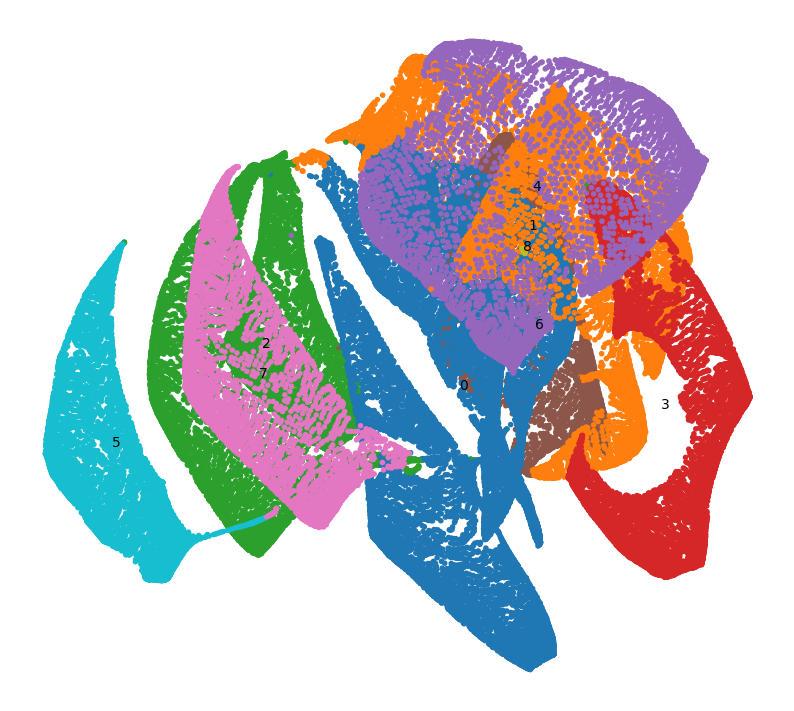

In [25]:
embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    nas_dir, 
    reducer_type='umap', 
    n_neighbors=15, 
    metric='manhattan',
    )

fig, ax, niches_color_mapper = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params, return_cmap=True)

In [ ]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 3, 
    'k_cluster': 15, 
    'resolution_parameter': 0.1,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

fig, ax = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

cluster_labels_2 = mosna.merge_clusters_until(cluster_labels, embed_viz, cond_n_clust=7, force_n_clust=True)
fig, ax = mosna.plot_clusters(embed_viz, cluster_labels_2, nas_dir, cluster_params=cluster_params)

Starting with high resolution and just merging until target number of clusters is reached can lead to poor merged clusters.

In [ ]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.1,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

fig, ax = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

cluster_labels = mosna.merge_clusters_until(cluster_labels, embed_viz)
fig, ax, niches_color_mapper = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params, return_cmap=True)

On the contrary, optimizing the resolution lead to better clustering.

In [ ]:
save_dir = cluster_dir / 'spatial_networks_niches'
save_dir.mkdir(parents=True, exist_ok=True)

# colormap for cell-types
# n_cell_types = obj['ClusterName'].unique().size
# palette = sns.color_palette(cc.glasbey, n_colors=n_cell_types).as_hex()
# palette = [mpl.colors.rgb2hex(x) for x in mpl.cm.get_cmap('tab20').colors]
niche_colors = np.array([niches_color_mapper[x] for x in cluster_labels])

plots_marker = '.'
for sample_id in uniq_samples:
    print(f"processing sample {sample_id}")
    select = adata.obs['sample'] == sample_id
    adaview = adata[select]
    patient_id = adaview.obs['patient'].iloc[0]

    coords = adaview.obsm['spatial']
    pairs = ty.build_lattice(coords)
    # add annotations
    nodes_labels = adaview.obs['layer_guess']

    # Big summary plot
    fig, ax = plt.subplots(1, 4, figsize=(int(7*4)+1, 7), tight_layout=False)
    i = 0
    ty.plot_network(
        coords, 
        pairs, 
        labels=nodes_labels,
        color_mapper=nodeclusters_color_mapper, 
        marker=plots_marker, 
        size_nodes=size_points, 
        ax=ax[i],
        # legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
        )
    ax[i].set_title('Spatial map of annotated regions', fontsize=14);

    i += 1
    ax[i].scatter(coords[:, 0], coords[:, 1], c=niche_colors[select], marker=plots_marker, s=size_points)
    ax[i].set_title('Spatial map of detected areas', fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[select, 0], embed_viz[select, 1], c=niche_colors[select], s=5);
    ax[i].set_title("Clustering on NAS", fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[:, 0], embed_viz[:, 1], c=niche_colors);
    ax[i].set_title("Clustering on NAS of all samples", fontsize=14);
    ax[i].set_aspect('equal')
    
    # make plot limits equal
    ax[i-1].set_xlim(ax[i].get_xlim())
    ax[i-1].set_ylim(ax[i].get_ylim())

    suptitle = f"Spatial omics data and detected areas - sample {sample_id}, patient {patient_id}";
    fig.suptitle(suptitle, fontsize=18)

    fig.savefig(save_dir / suptitle, bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

### NAS analysis on single sample

In [27]:
sample_id = '151508'

nas_dir = nas_dir / 'select_sample'
nas_dir.mkdir(parents=True, exist_ok=True)

select_sample = var_aggreg_samples_info['sample'] == sample_id
var_aggreg = var_aggreg.iloc[select_sample.values, :]
var_aggreg.to_parquet(nas_dir / f'aggregation_statistics.parquet', index=False)
adata = adata[adata.obs['sample'] ==  sample_id]

In [ ]:
# cluster_labels = cluster_labels[select_sample]
# embed_viz = embed_viz[select_sample]

In [38]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 3, 
    'k_cluster': 15, 
    'resolution_parameter': 0.2,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Performing clustering
Loading reducer object and reduced coordinates
Found 6 clusters


Loading reducer object and reduced coordinates


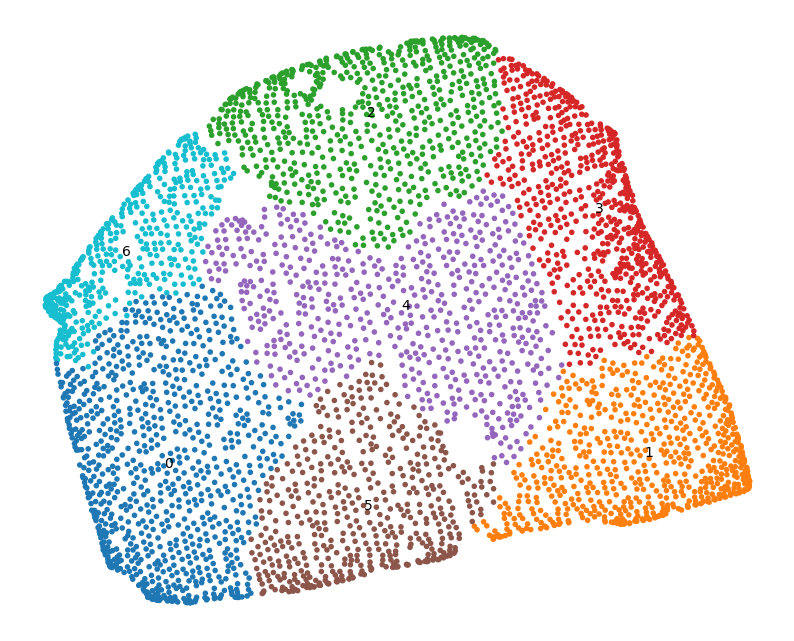

In [44]:
embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    nas_dir, 
    reducer_type='umap', 
    n_neighbors=15, 
    metric='manhattan',
    )

fig, ax, niches_color_mapper = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params, return_cmap=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


processing sample 151508


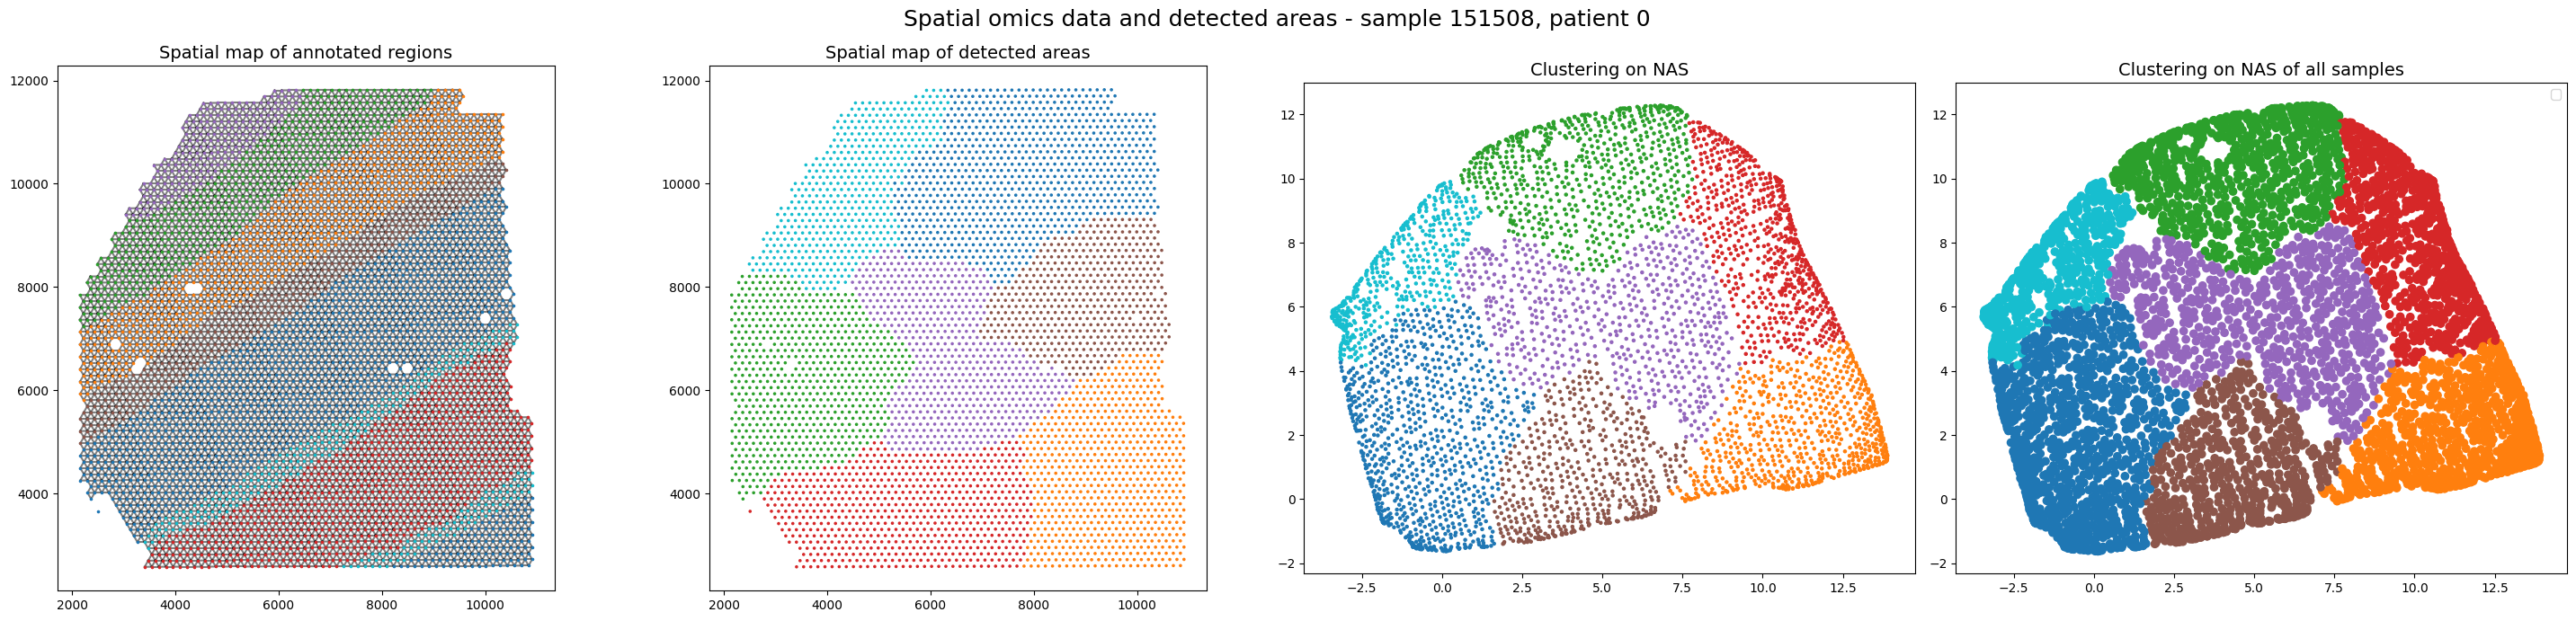

In [40]:
save_dir = cluster_dir / 'spatial_networks_niches'
save_dir.mkdir(parents=True, exist_ok=True)


niche_colors = np.array([niches_color_mapper[x] for x in cluster_labels])

plots_marker = '.'
sample_id
print(f"processing sample {sample_id}")
select = adata.obs['sample'] == sample_id
adaview = adata[select]
patient_id = adaview.obs['patient'].iloc[0]

coords = adaview.obsm['spatial']
pairs = ty.build_lattice(coords)
# add annotations
nodes_labels = adaview.obs['layer_guess']

# Big summary plot
fig, ax = plt.subplots(1, 4, figsize=(int(7*4)+1, 7), tight_layout=False)
i = 0
ty.plot_network(
    coords, 
    pairs, 
    labels=nodes_labels,
    color_mapper=nodeclusters_color_mapper, 
    marker=plots_marker, 
    size_nodes=size_points, 
    ax=ax[i],
    # legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
    )
ax[i].set_title('Spatial map of annotated regions', fontsize=14);

i += 1
ax[i].scatter(coords[:, 0], coords[:, 1], c=niche_colors, marker=plots_marker, s=size_points)
ax[i].set_title('Spatial map of detected areas', fontsize=14);
ax[i].set_aspect('equal')

i += 1
ax[i].scatter(embed_viz[:, 0], embed_viz[:, 1], c=niche_colors[select], s=5);
ax[i].set_title("Clustering on NAS", fontsize=14);
ax[i].set_aspect('equal')

i += 1
ax[i].scatter(embed_viz[:, 0], embed_viz[:, 1], c=niche_colors);
ax[i].set_title("Clustering on NAS of all samples", fontsize=14);
ax[i].set_aspect('equal')

# make plot limits equal
ax[i-1].set_xlim(ax[i].get_xlim())
ax[i-1].set_ylim(ax[i].get_ylim())

suptitle = f"Spatial omics data and detected areas - sample {sample_id}, patient {patient_id}";
fig.suptitle(suptitle, fontsize=18)

fig.savefig(save_dir / suptitle, bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

## Check DEG between layers

Given the hard time finding back annotated layers with the NAS method, I'll directly inspect genes between layers, and select the DEGs to check if using them we can find layers with the NAS method.  

In [6]:
# cohort aggregation, preprocessing performed on whole cohort
remove_none_spots = True
hvg_on = 'annotations' # or 'all or 'patient'
n_common_batches = 9
str_preprocess += f'_hvg_on-{hvg_on}'

adatas = []
for sample_id, n_clusters in cluster_ids.items():
    sample_dir = data_dir / f'{sample_id}'
    adata = sc.read_visium(path=sample_dir)
    adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata.obs['sample'] = [sample_id] * adata.shape[0]
    adata.obs['patient'] = [patient_ids[sample_id]] * adata.shape[0]

    # make unique barcodes with sample_id
    adata.obs.index = adata.obs.index + '-' + str(sample_id)
    
    adatas.append(adata)

adata = ad.concat(adatas, pairwise=True)
# adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# skip HVG detection

# add manual annotations
layer_guess = annotations.copy()
layer_guess.index = layer_guess['barcodes']
layer_guess.index.name = None
layer_guess = layer_guess.drop(columns=['barcodes', 'sample_id'])
adata.obs['layer_guess'] = layer_guess
if remove_none_spots:
    adata = adata[~adata.obs['layer_guess'].isna()]
else:
    adata.obs.loc[adata.obs['layer_guess'].isna(), 'layer_guess'] = 'none'

# make common color mapper
nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = len(uniq)
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [11]:
sc.tl.rank_genes_groups(adata, groupby='layer_guess', method='logreg', key_added='logreg', max_iter=500)

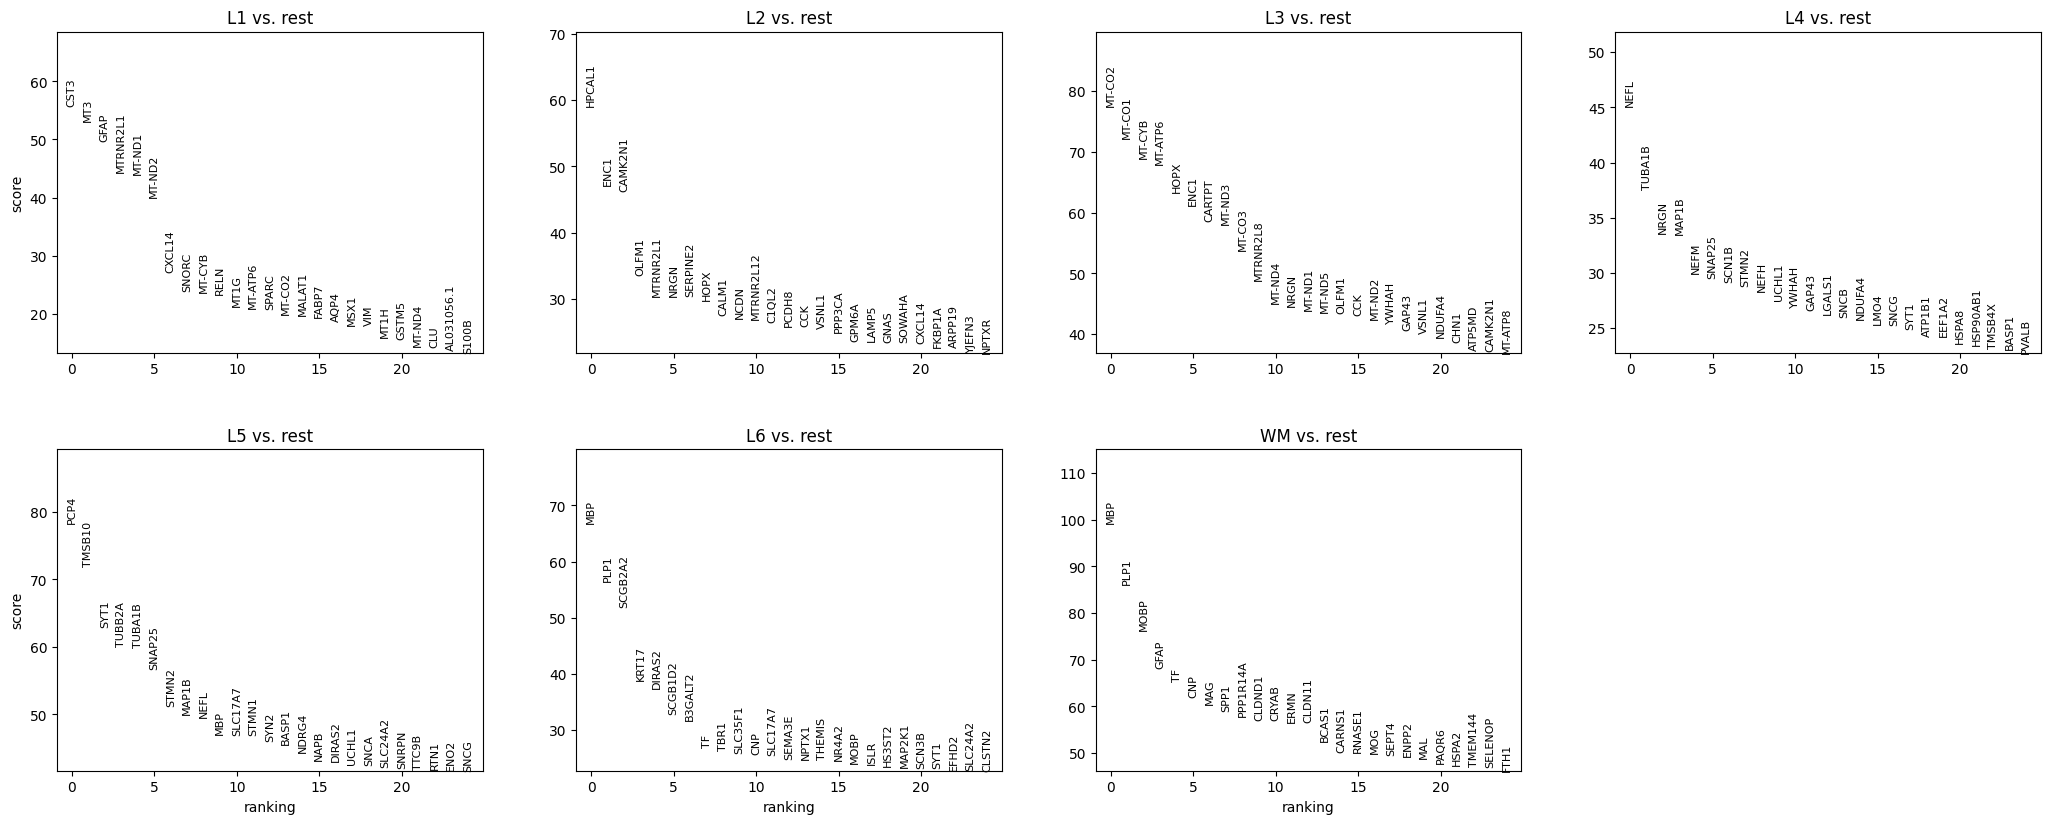

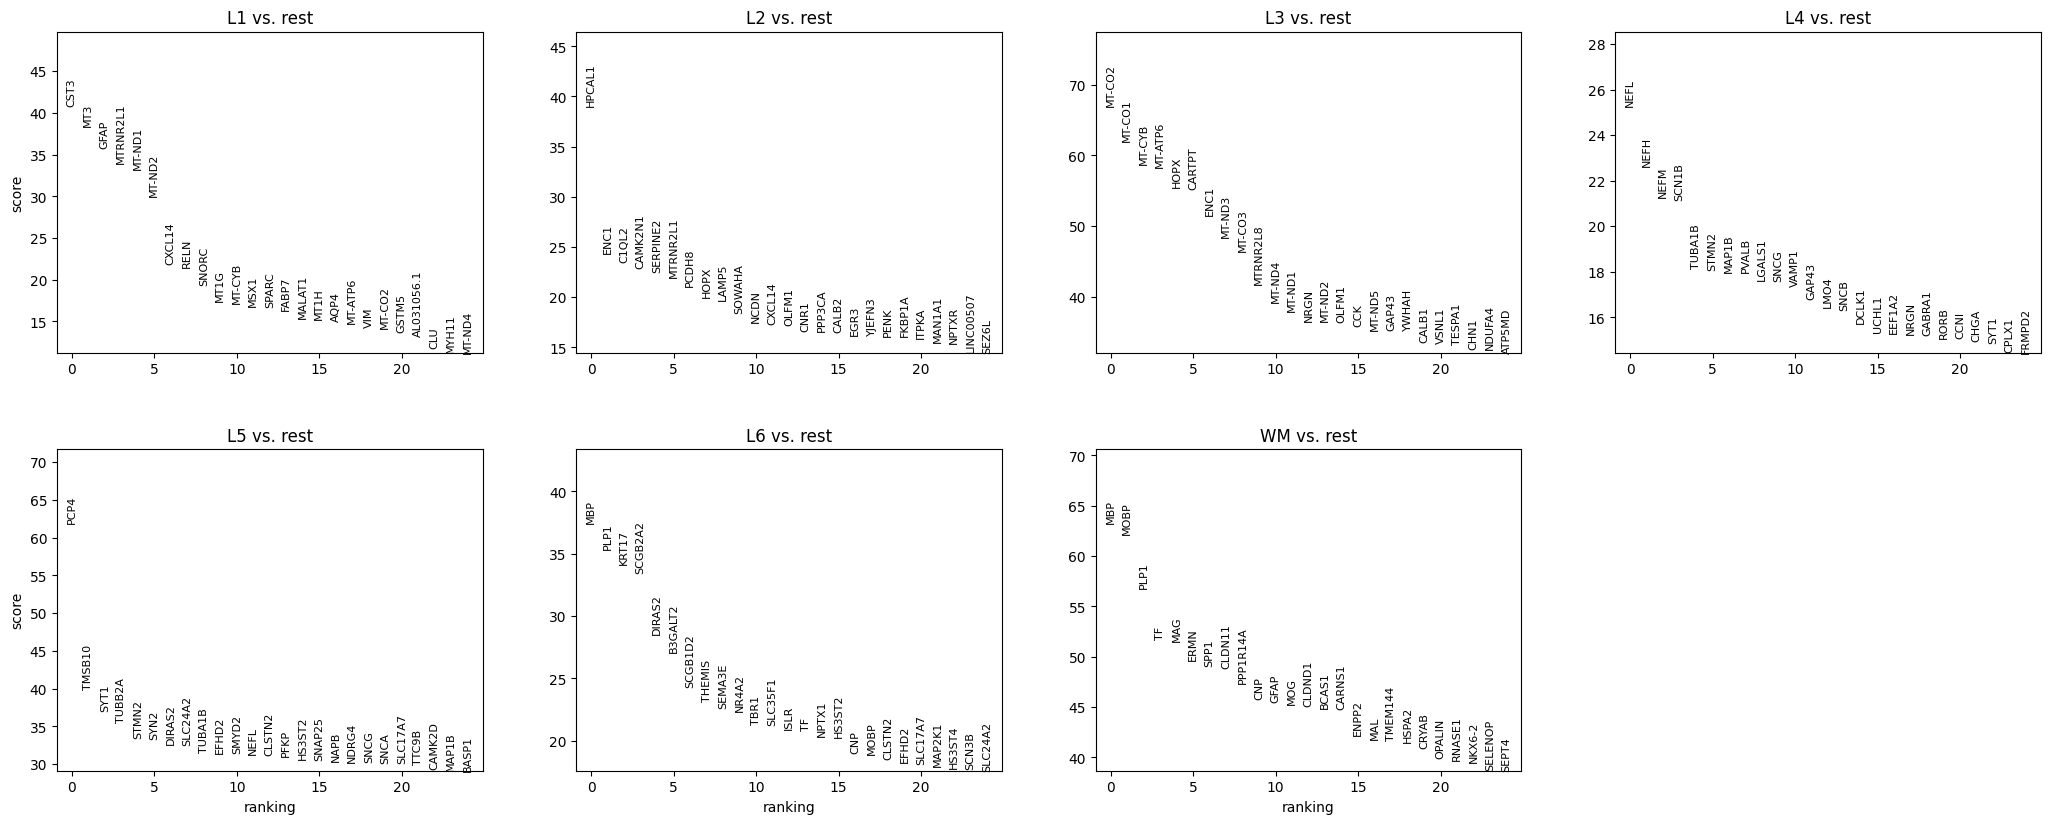

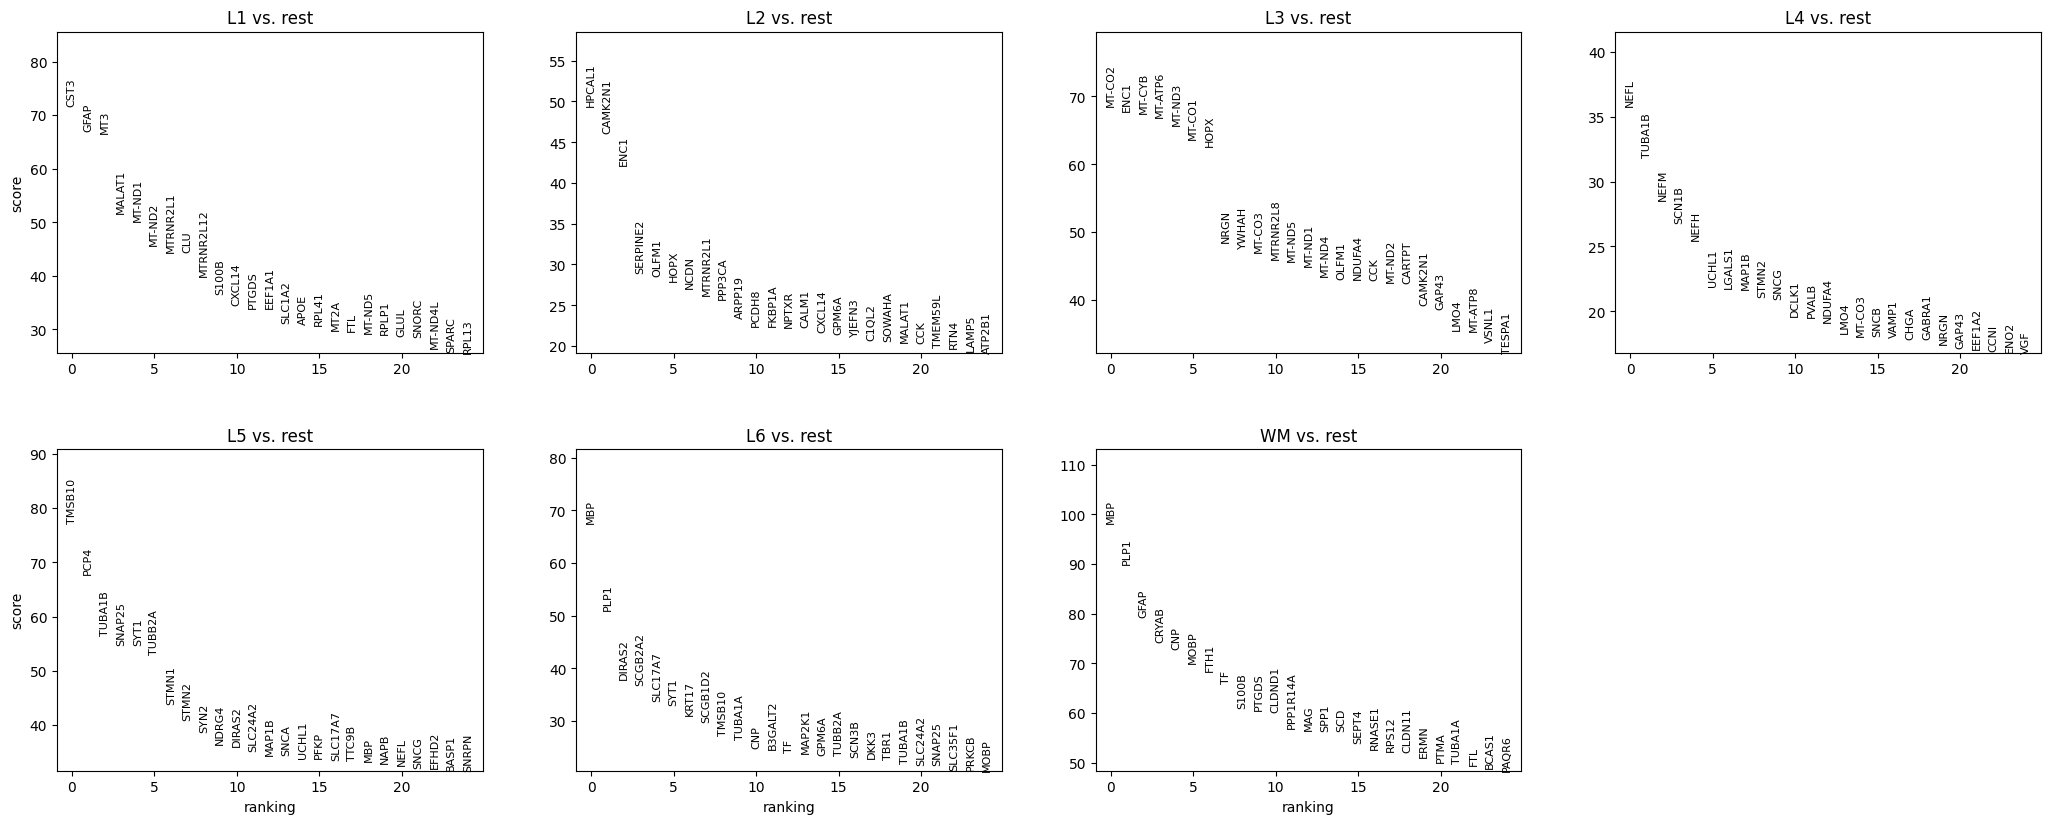

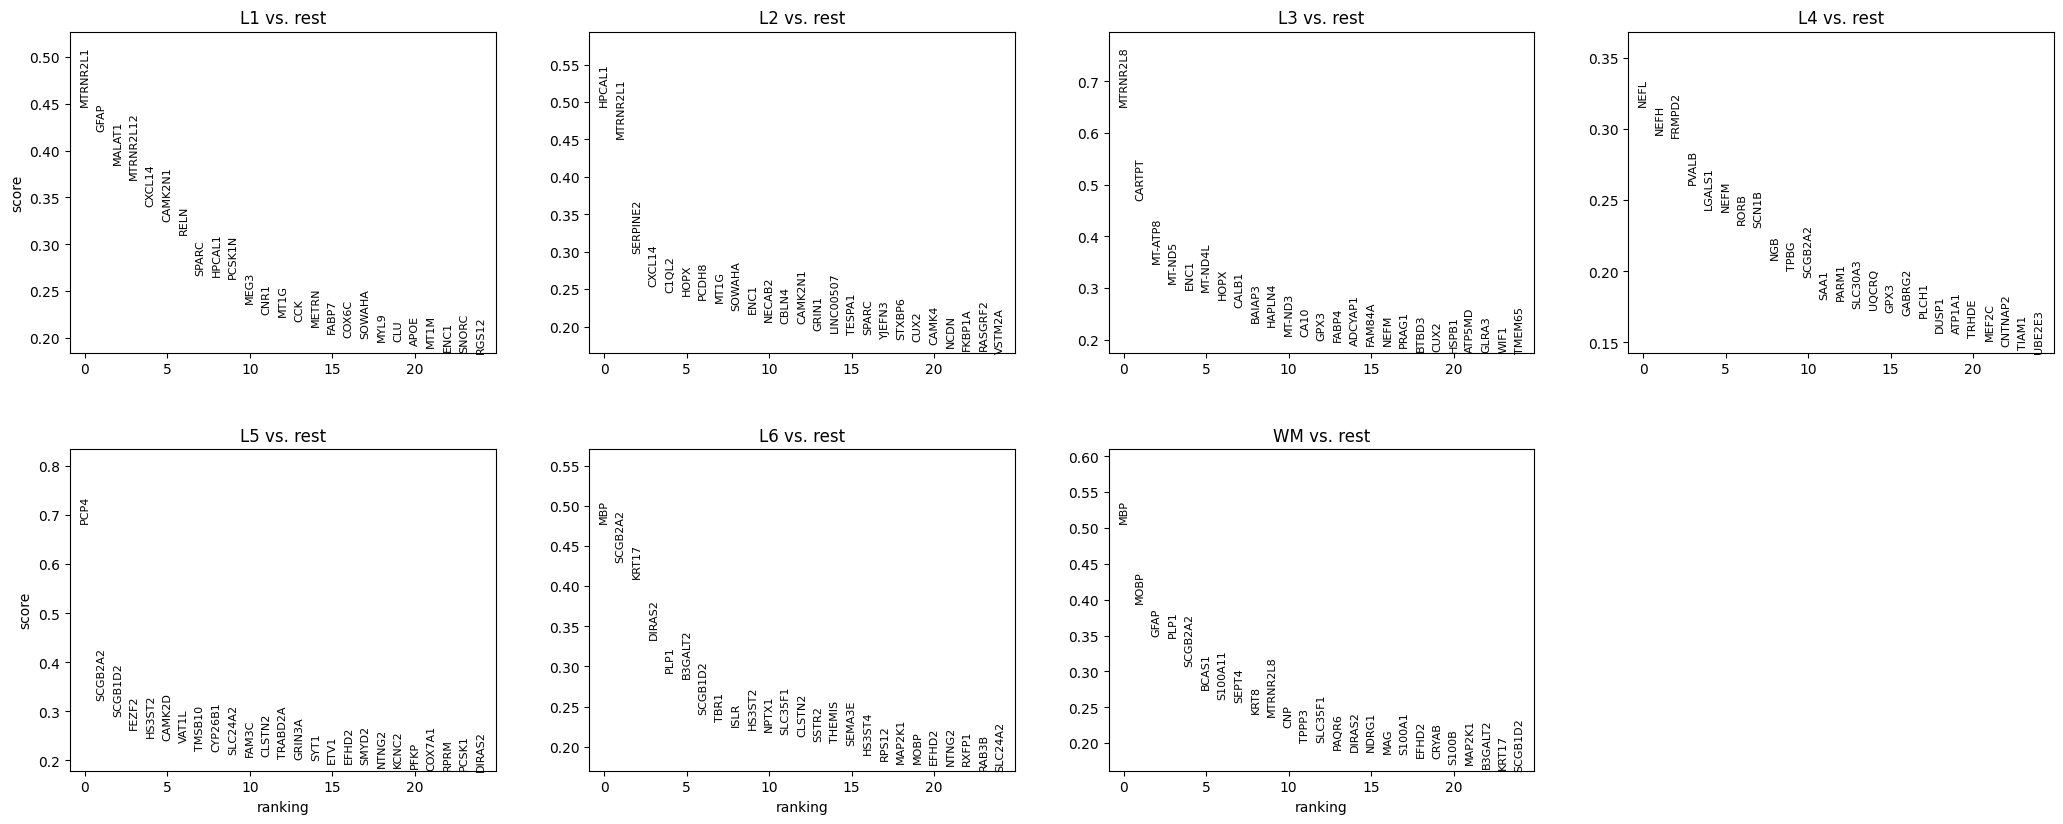

In [13]:
methods = ['t-test', 't-test_overestim_var', 'wilcoxon']#, 'logreg']
for method in methods:
    sc.tl.rank_genes_groups(adata, groupby='layer_guess', method=method, key_added=method)
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key=method)

methods = ['t-test', 't-test_overestim_var', 'wilcoxon', 'logreg']
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='logreg')

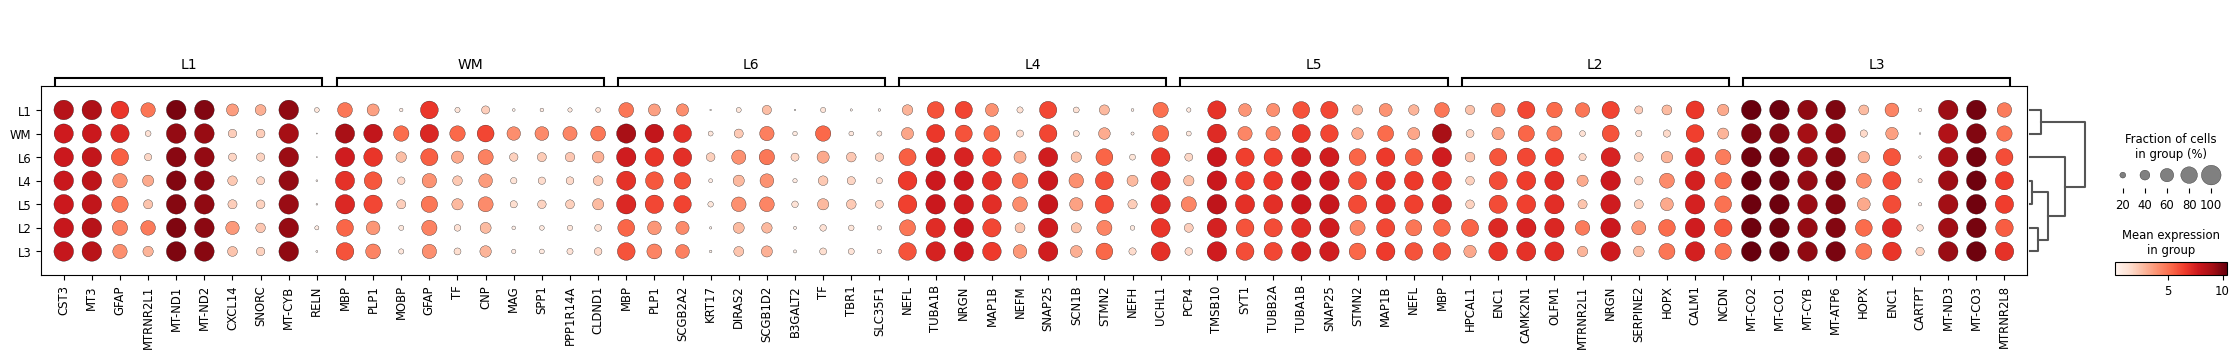

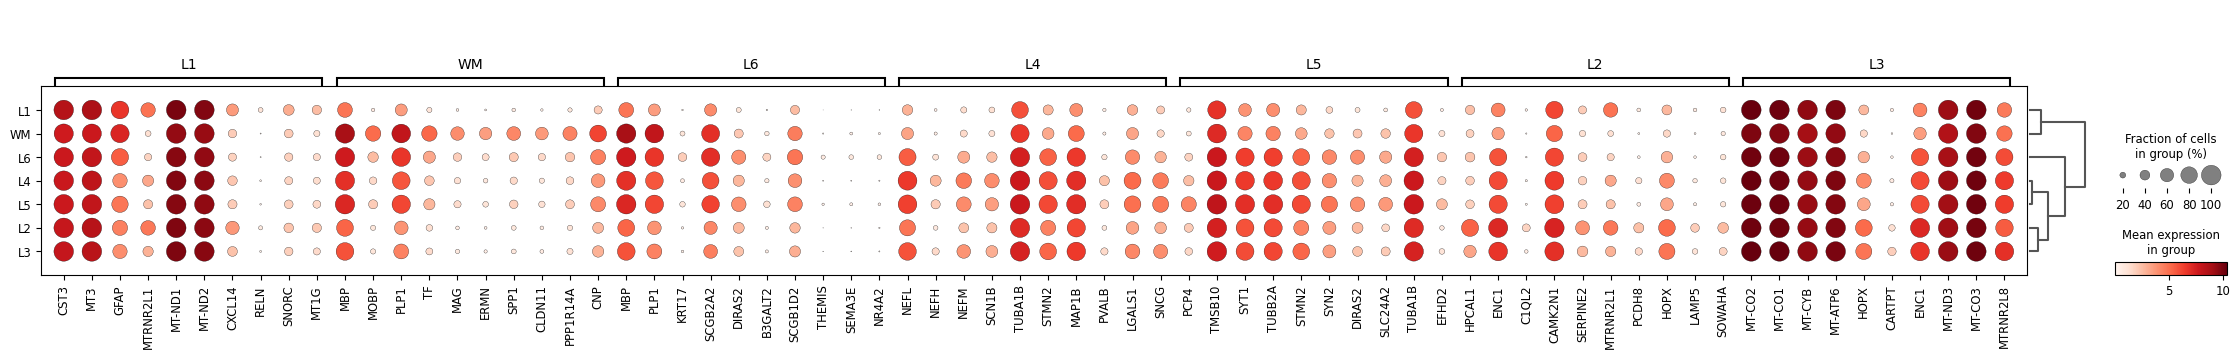

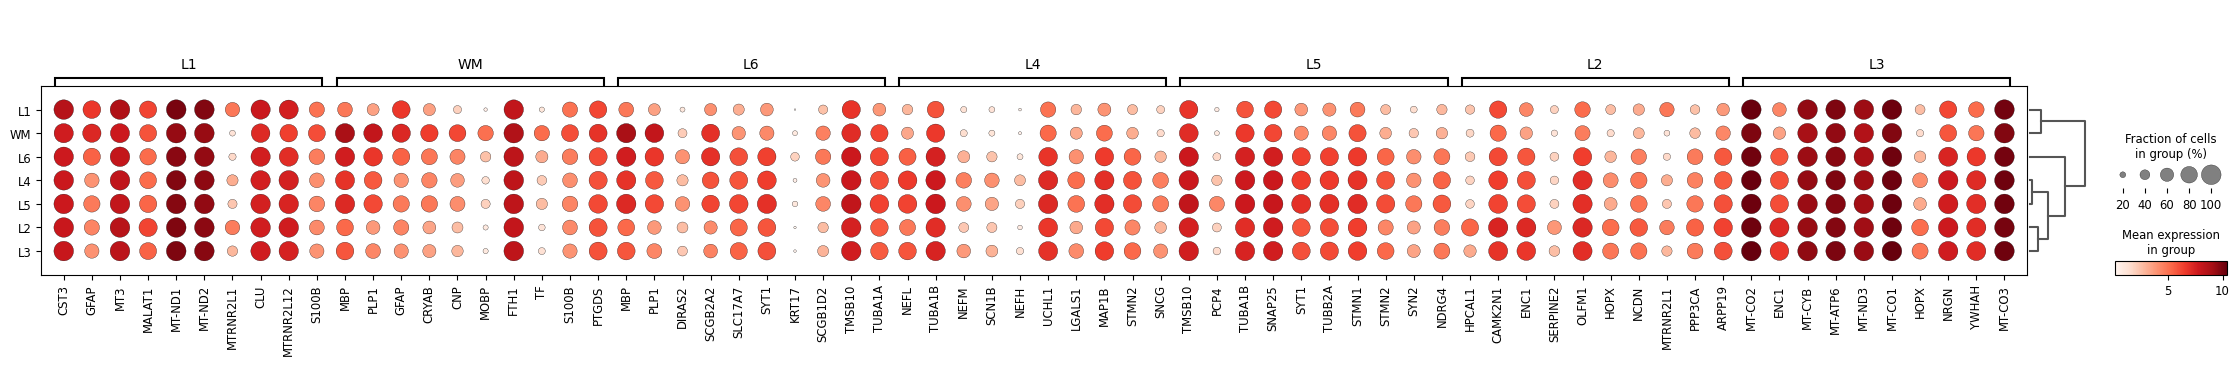

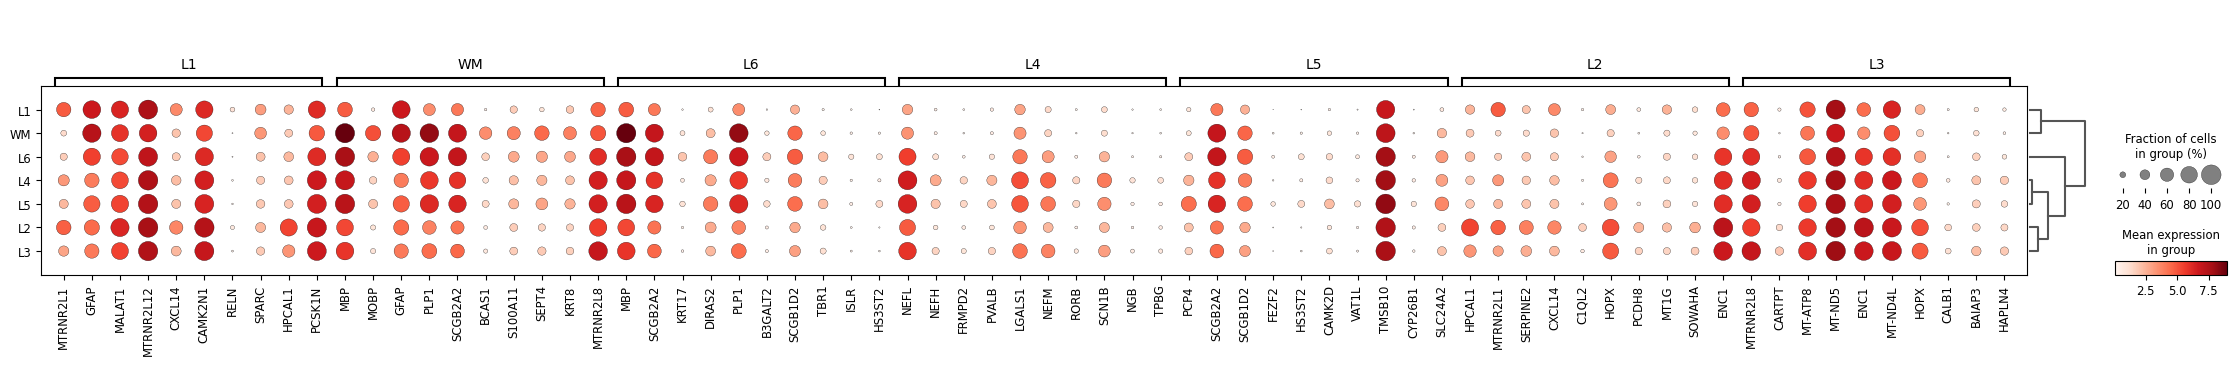

In [24]:
# sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="layer_guess", show_gene_labels=True)
for method in methods:
    fig = sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key=method, groupby="layer_guess")

### on single sample

In [25]:
sample_id = '151508'
adasample = adata[adata.obs['sample'] ==  sample_id]

In [26]:
sc.tl.rank_genes_groups(adasample, groupby='layer_guess', method='logreg', key_added='logreg', max_iter=500)

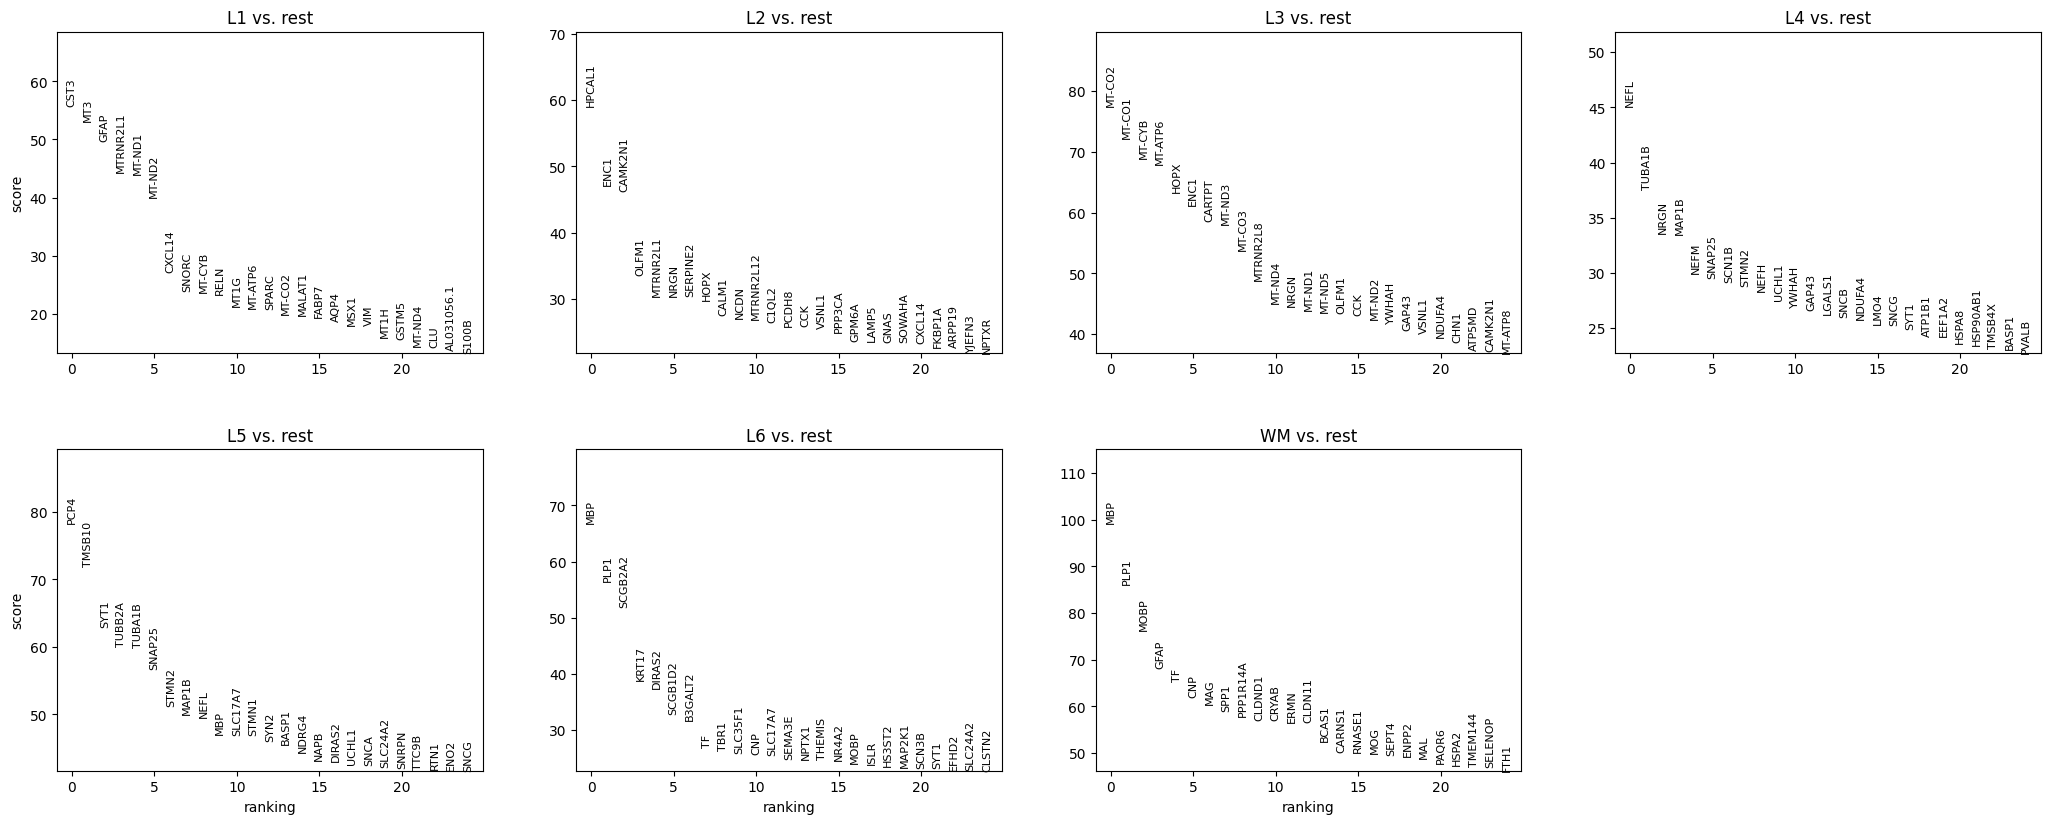

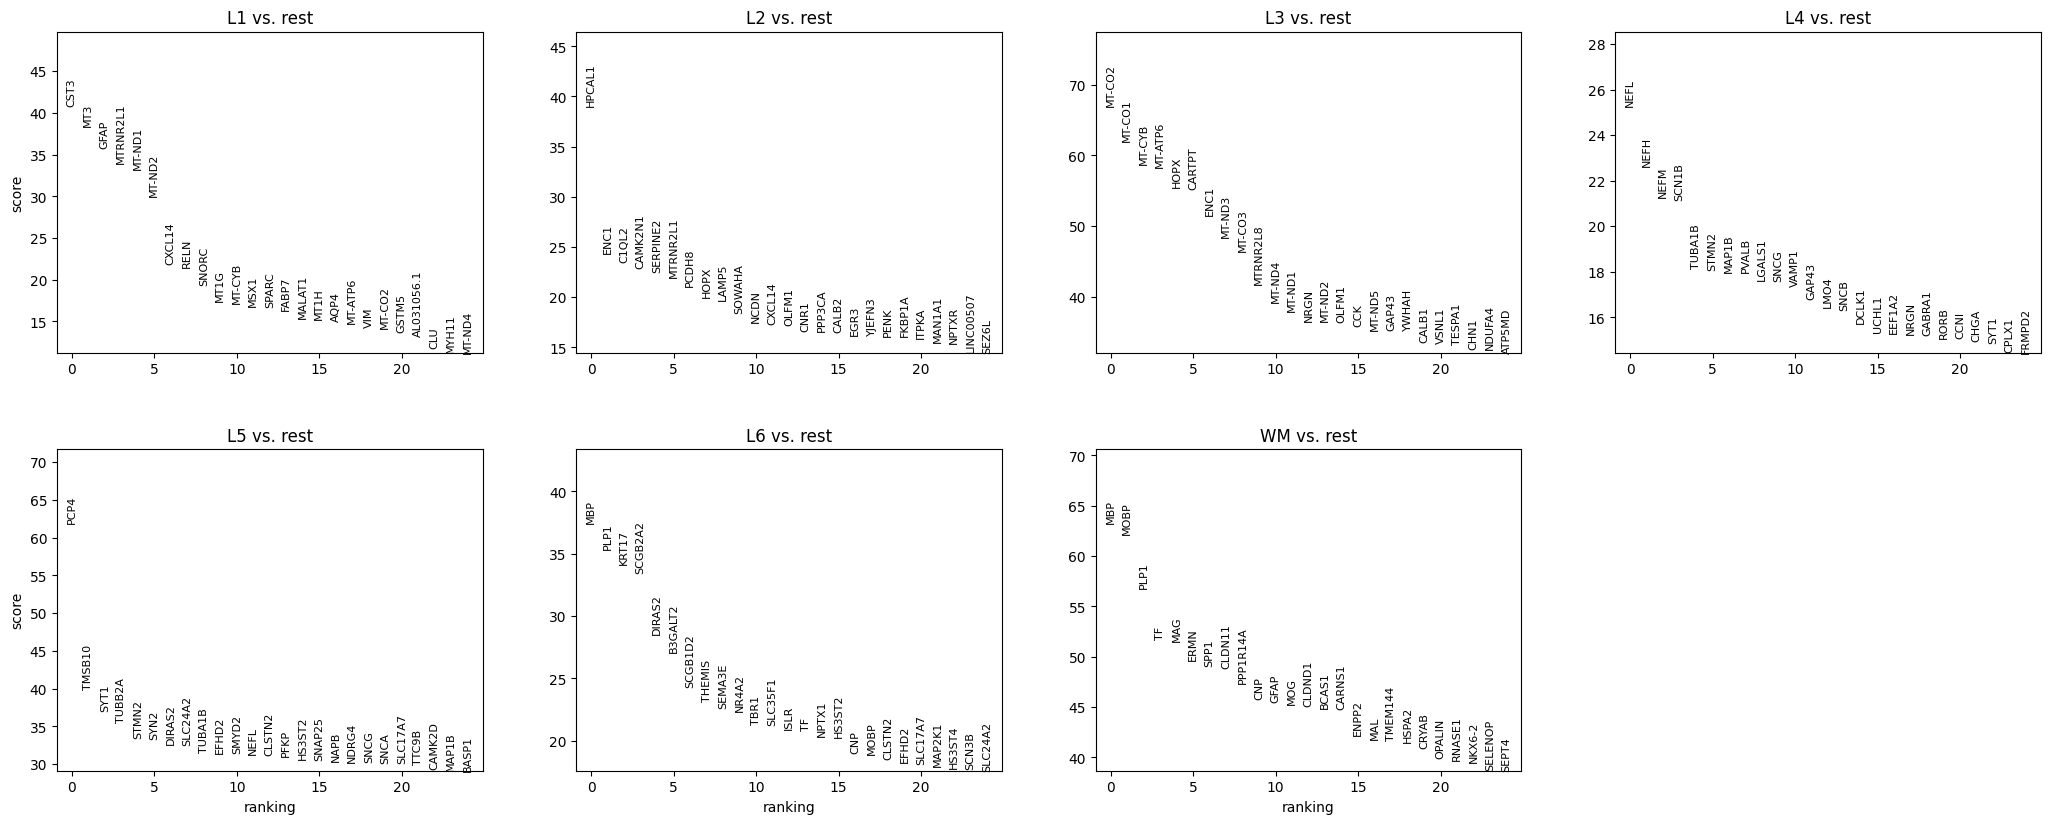

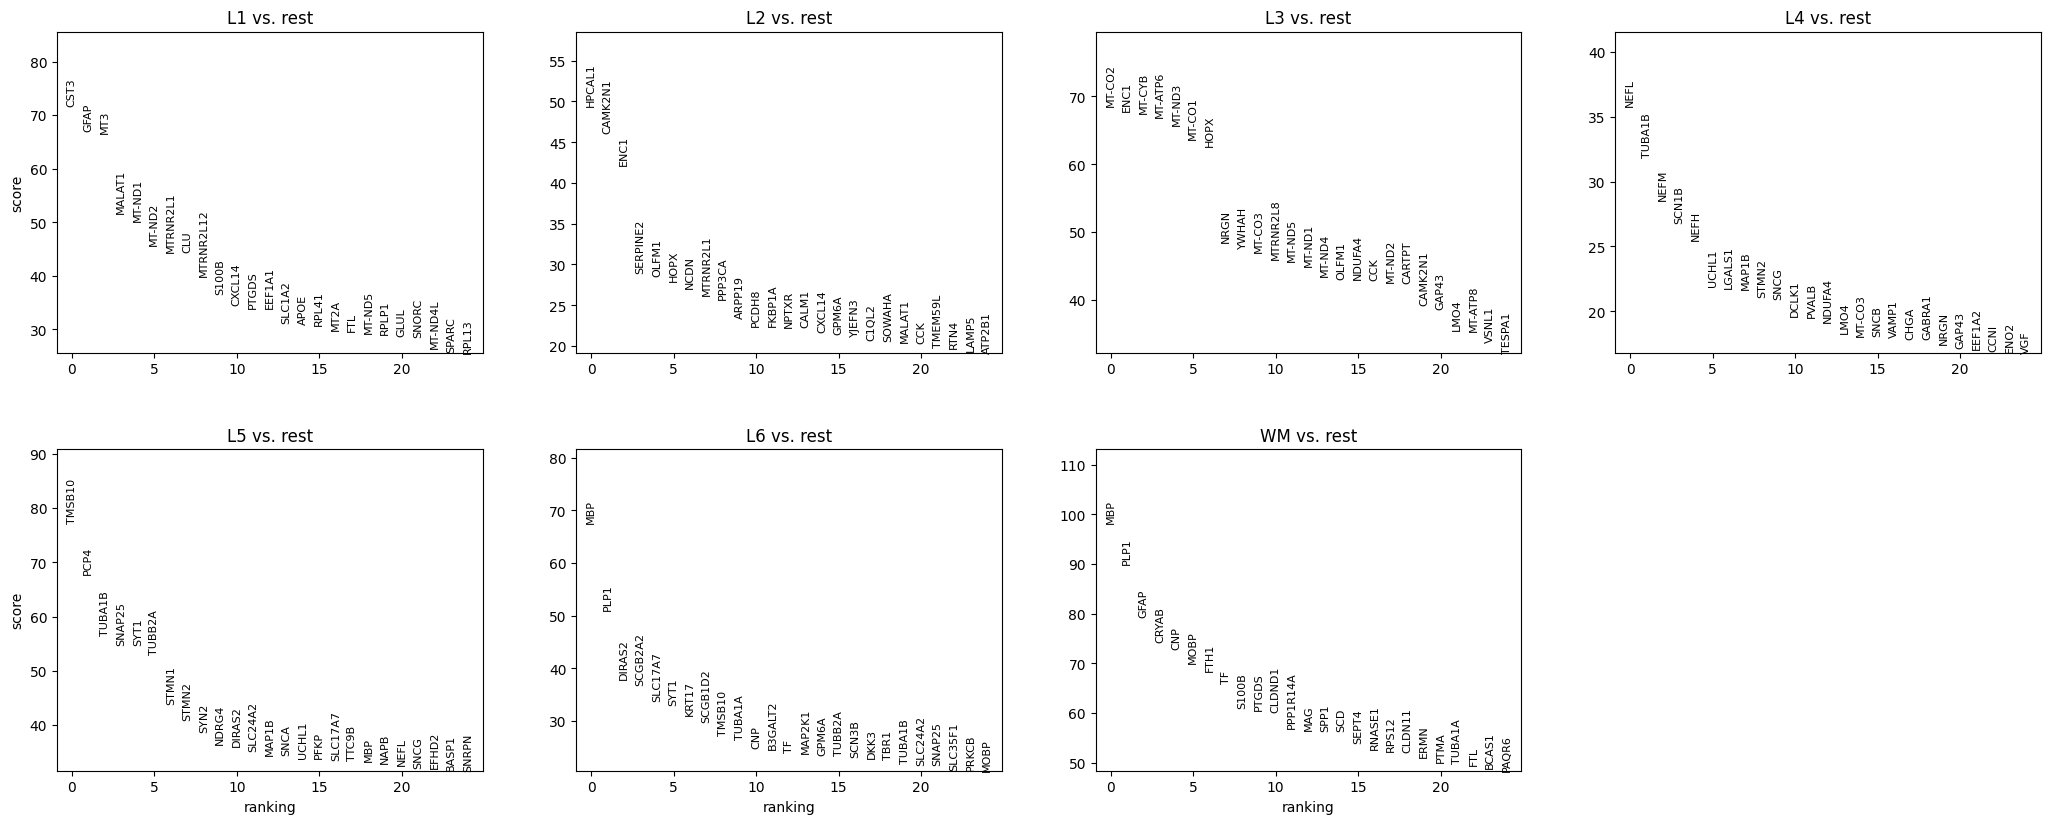

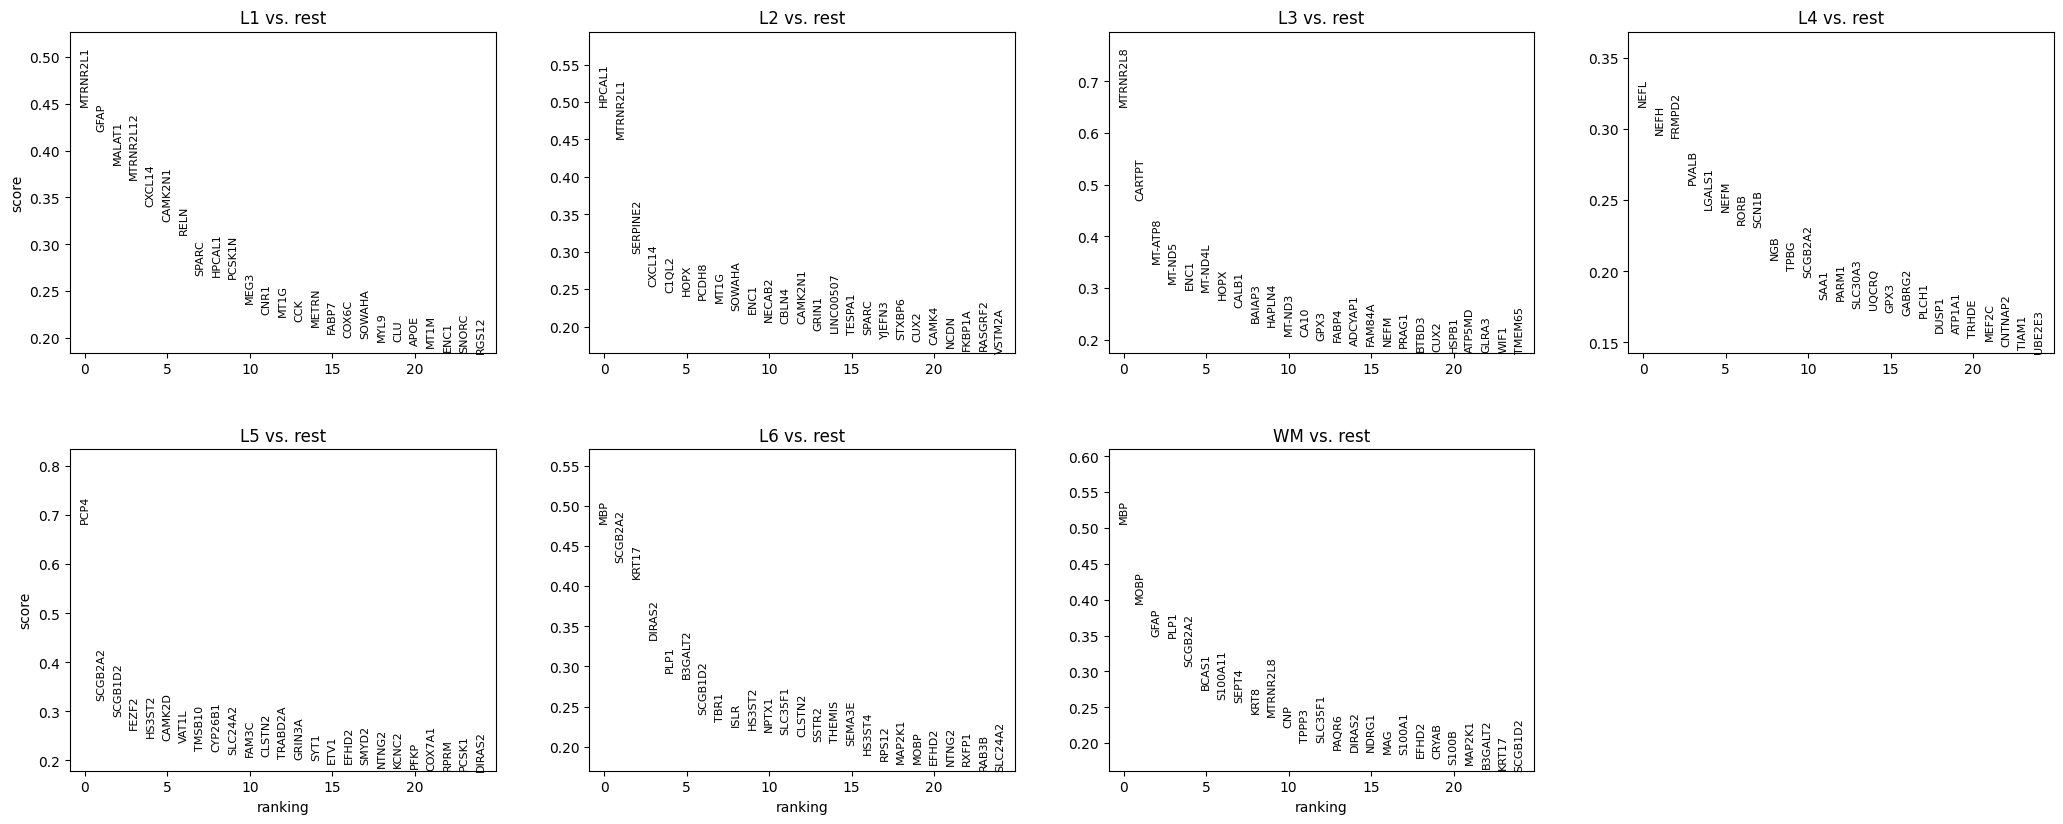

In [27]:
methods = ['t-test', 't-test_overestim_var', 'wilcoxon']#, 'logreg']
for method in methods:
    sc.tl.rank_genes_groups(adata, groupby='layer_guess', method=method, key_added=method)
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key=method)

methods = ['t-test', 't-test_overestim_var', 'wilcoxon', 'logreg']
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='logreg')

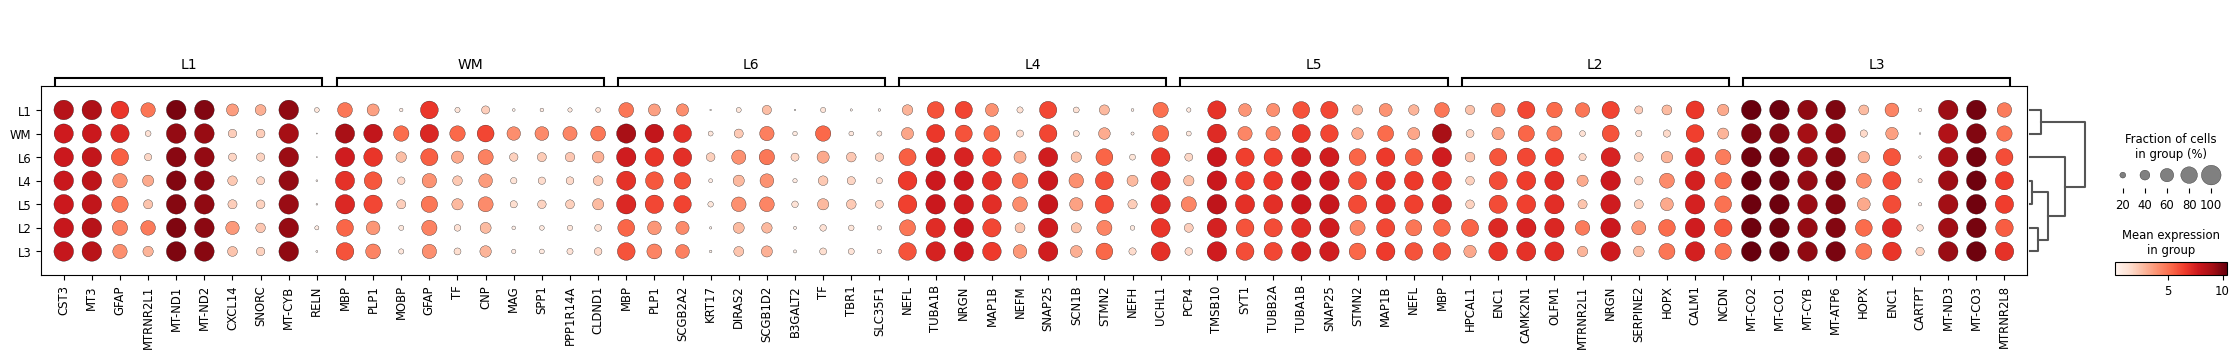

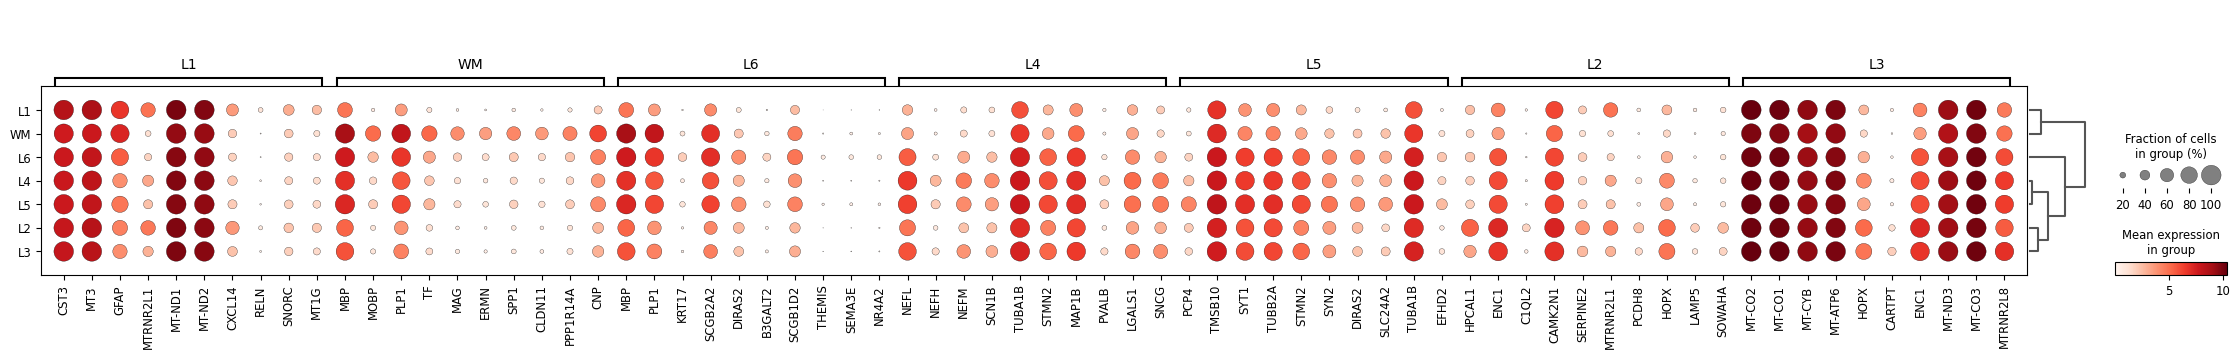

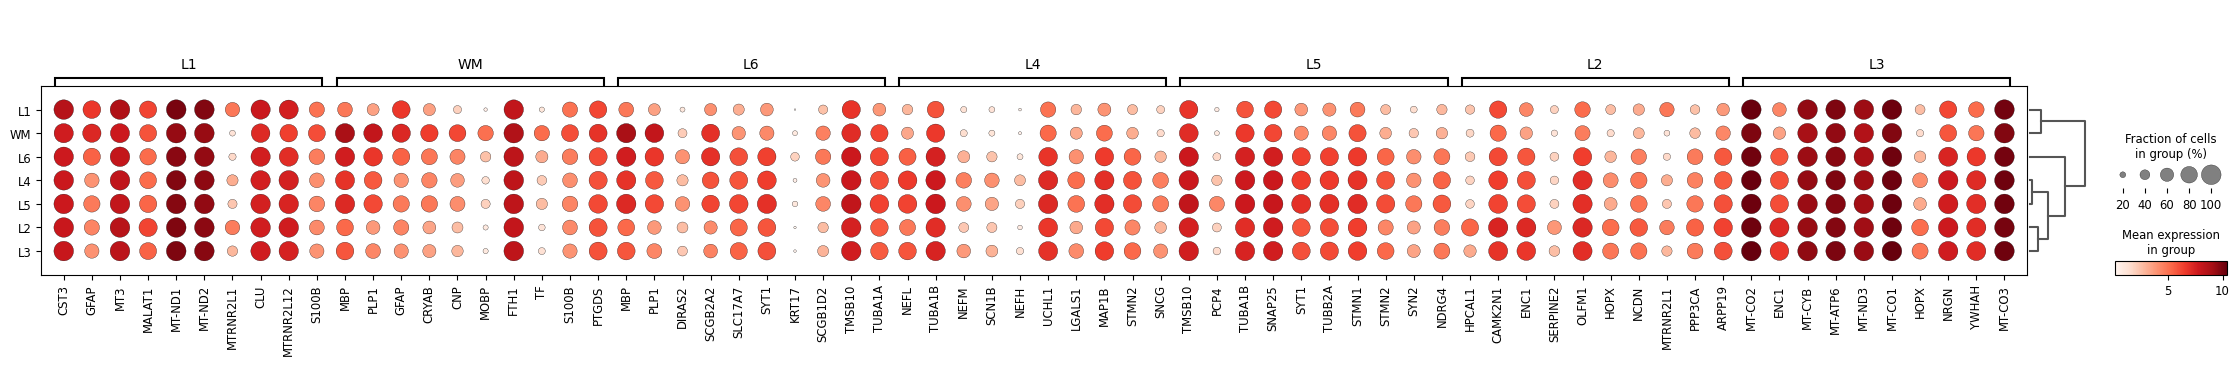

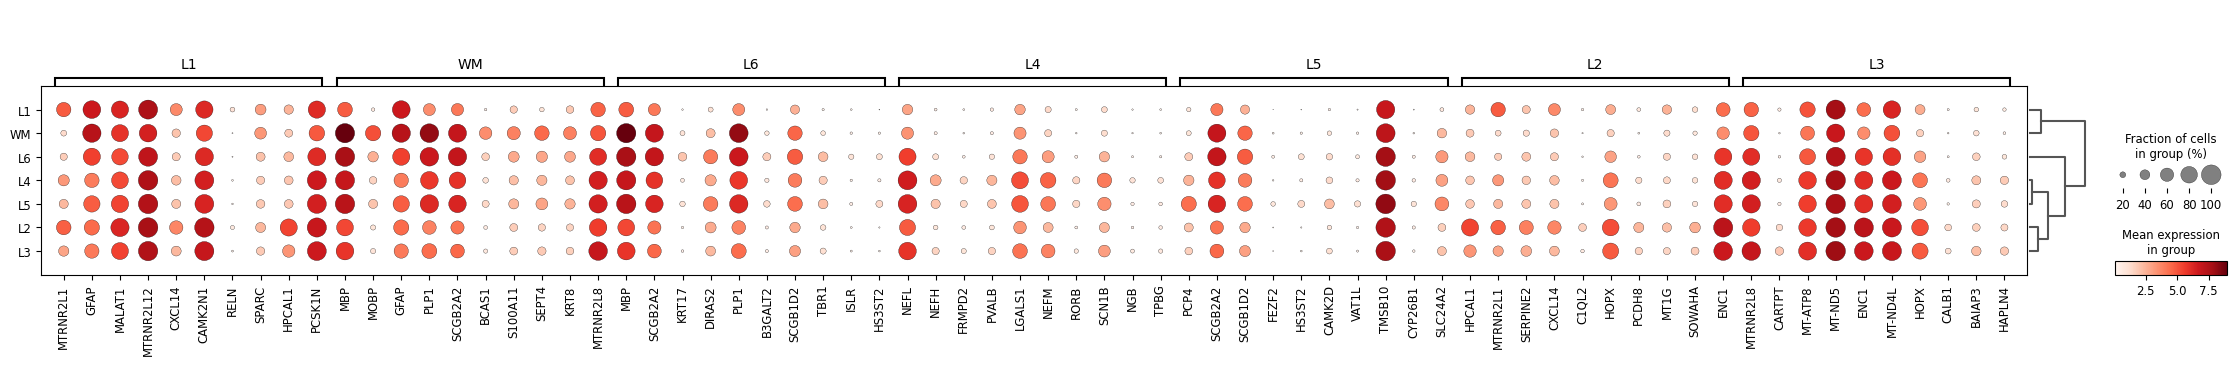

In [28]:
# sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="layer_guess", show_gene_labels=True)
for method in methods:
    fig = sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key=method, groupby="layer_guess")